__Support Vector Machine Implementation for Predicting Stock Price Movement__

In [4]:
# Implementing Support Vector machines model on dataset for stock price prediction
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import yfinance as yf
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle

# Importing the dataset
#initial_df = pd.read_csv('SP500_stock_dataset_PE.csv', delimiter=',')
initial_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
initial_df = initial_df.set_index('Date')

initial_df.head()

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,Industrials
2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,Industrials
2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,Industrials
2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,Industrials
2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,Industrials


In [5]:
# only display year, month and day in index
initial_df.index = pd.to_datetime(initial_df.index).date
initial_df_test = initial_df.copy()
data = initial_df
data
# make return column
data['Return'] = data['Close'].pct_change()

In [6]:
print(data['Sector'].unique())
# assign each different Sector string its own number
data['Sector'] = data['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Consumer Discretionary'
 'Utilities' 'Financials' 'Materials' 'Real Estate' 'Energy']


In [7]:
# make a new column for whether or not the price has increased or decreased from the previous 63 days
# 1 = increased, 0 = decreased, doing so by comparing close price of today with close price of 63 days ago
data['63-day Price Movement'] = np.where(data['Close'] > data['Close'].shift(-63), 1, 0)

In [8]:
# Make the tickers to categoricals, but keep the original order of the tickers
data['Ticker'] = pd.Categorical(data['Ticker'], categories=data['Ticker'].unique(), ordered=True)
data['Ticker'] = data['Ticker'].cat.codes

In [9]:
# select only the ticker index
indiviual_datas = []

for ticker in data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = data[data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['Target'] = data_ticker['63-day Price Movement'].shift(-63)
    #data['Price Movement 62 Days'] = data['Price Movement'].shift(62)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)

data_all_tickers

,Ticker,Open,Low,High,Close,Volume,Sector,Return,63-day Price Movement,Target
2016-01-05,0,146.820007,145.610001,147.500000,147.460007,2688100,5,0.004359,0,0.0
2016-01-06,0,145.589996,143.419998,145.759995,144.490005,2997100,5,-0.020141,0,0.0
2016-01-07,0,142.520004,140.630005,143.130005,140.970001,3553500,5,-0.024362,0,0.0
2016-01-08,0,141.360001,140.220001,142.500000,140.490005,2664000,5,-0.003405,0,0.0
2016-01-11,0,140.970001,139.410004,141.429993,140.460007,2775500,5,-0.000214,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,496,132.210007,131.289993,133.080002,132.919998,442500,4,0.004155,1,0.0
2019-12-26,496,133.190002,132.320007,133.190002,133.029999,929400,4,0.000828,1,0.0
2019-12-27,496,133.399994,132.380005,133.479996,133.250000,1296100,4,0.001654,1,0.0
2019-12-30,496,133.570007,131.809998,133.660004,132.210007,942000,4,-0.007805,1,0.0


In [10]:
# Splitting the dataset into the Training set and Test set according to date
# Define the specific date to split the DataFrame
# Create an offset of 62 Business days
# bd = pd.tseries.offsets.BusinessDay(n = 63)
# split_date = pd.to_datetime('2019-09-30') - bd

# # set a start date for the training set to be 62 days after the first date in the dataset
# start_date = pd.to_datetime('2016-01-04') + bd

# small test dataset creation:

bd = pd.tseries.offsets.BusinessDay(n = 63)
split_date = pd.to_datetime('2019-12-27') - bd
start_date = pd.to_datetime('2018-09-30') + bd


# Split the DataFrame into training and test sets based on the specific date
# for train we want all the data from the start date to the split date, this ensures that we have 63 days of data for each stock
# for test we want all the data from the split date to the end of the dataset
train = data_all_tickers.loc[(start_date < data_all_tickers.index) & (data_all_tickers.index < split_date)]
train_log = train
train_log['Low'] = np.log(train_log['Low'])
train_log['High'] = np.log(train_log['High'])
train_log['Open'] = np.log(train_log['Open'])
train_log['Close'] = np.log(train_log['Close'])
train_log['Volume'] = np.log(train_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#train_log['Volume'] = np.log(train_log['Volume'])
test = data_all_tickers.loc[data_all_tickers.index >= split_date]
test_log = test
test_log['Low'] = np.log(test_log['Low'])
test_log['High'] = np.log(test_log['High'])
test_log['Open'] = np.log(test_log['Open'])
test_log['Close'] = np.log(test_log['Close'])
test_log['Volume'] = np.log(test_log['Volume']).apply(lambda x: np.log(x) if x > 0 else 0)
#X_train = train_log[['Ticker','Close', 'Volume', 'Sector']]
X_train = train_log[['Ticker','Open', 'Low', 'High','Close', 'Volume', 'Sector']]
y_train = train['Target']
X_test = test_log[['Ticker', 'Open', 'Low', 'High','Close', 'Volume', 'Sector']]
#X_test = test_log[['Ticker', 'Close', 'Volume', 'Sector']]
y_test = test['Target']

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\2708441104.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_log['Low'] = np.log(train_log['Low'])
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\2708441104.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM model
model = SVC(kernel='rbf',probability=True) # linear, rbf, poly, sigmoid
model.fit(X_train, y_train)

SVC(probability=True)

In [206]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# shuffle the data, but ensure that the X and y data are shuffled in the same way.
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=69)

# Convert categorical variables to dummy variables
X_train_shuffled = pd.get_dummies(X_train_shuffled, columns=['Ticker', 'Sector'])

# Split the data into training and testing sets
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_train_shuffled, y_train_shuffled, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train_RF, y_train_RF)

# Make predictions on the test set
y_pred = rf.predict(X_test_RF)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_RF, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')




Root Mean Squared Error: 0.3897910960206962


In [209]:

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({"feature": X_train.columns, "importance": importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Print the feature importances
print(feature_importances[0:20])


        feature  importance
4        Volume    0.173235
2          High    0.142522
3         Close    0.137208
0          Open    0.136931
1           Low    0.132762
503    Sector_2    0.013996
507    Sector_6    0.003647
506    Sector_5    0.003603
504    Sector_3    0.003530
509    Sector_8    0.003381
501    Sector_0    0.003328
508    Sector_7    0.003315
505    Sector_4    0.003238
502    Sector_1    0.002876
511   Sector_10    0.002417
417  Ticker_414    0.002295
510    Sector_9    0.002206
53    Ticker_48    0.001989
413  Ticker_410    0.001783
212  Ticker_208    0.001742


In [13]:
# get probabilities for each class (training set)
y_pred_proba_train = model.predict_proba(X_train)
y_scores_train = y_pred_proba_train[:, 1]

In [14]:
# Get the probabilities for each class
y_pred_proba_test = model.predict_proba(X_test)
# predicted probabilities for the positive class
y_scores_test = y_pred_proba_test[:, 1]

In [15]:
# save the y_pred_proba_test to a csv file
y_pred_proba_test_df = pd.DataFrame(y_pred_proba_test)
y_pred_proba_test_df.to_csv('SVM_y_pred_proba_test.csv')

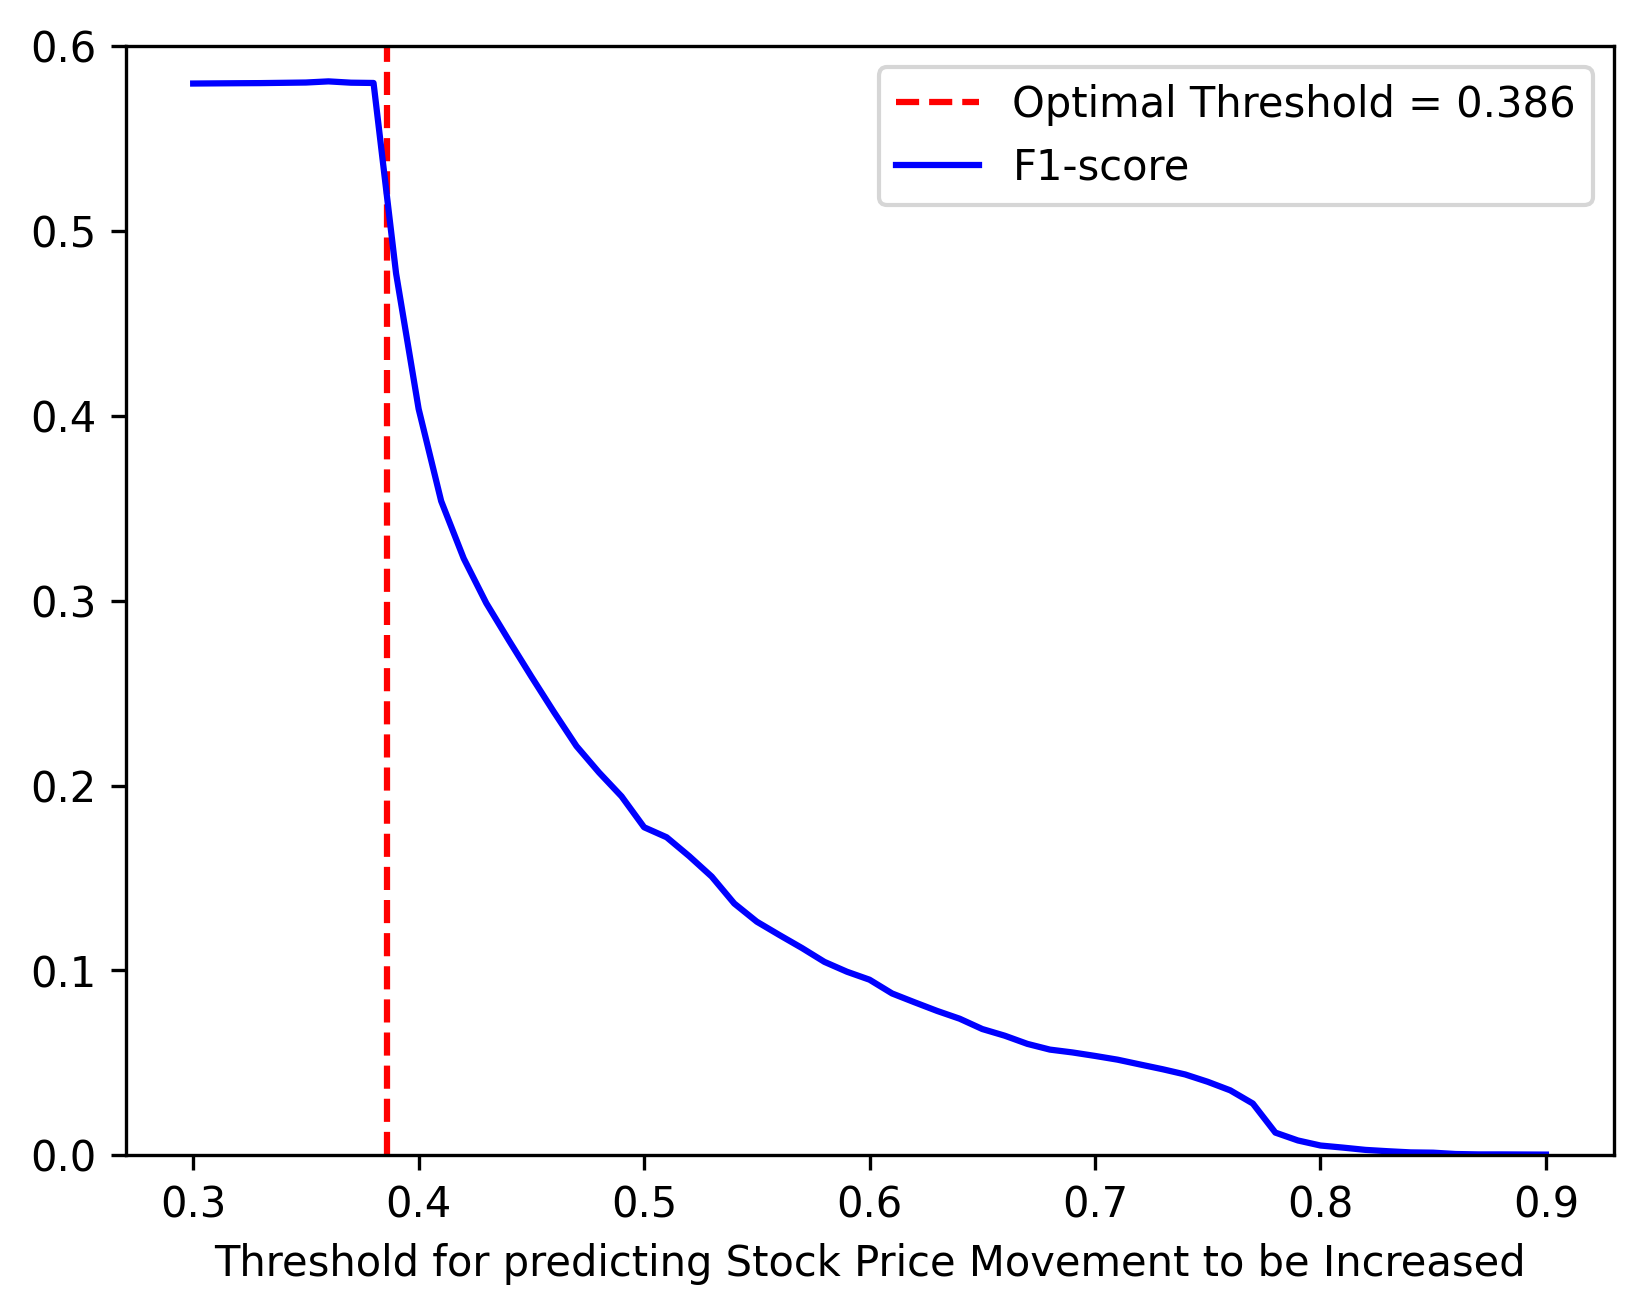

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

precision = []
recall = []
f1 = []
thresholds = np.arange(0.3, 0.9, 0.01)
for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    precision.append(precision_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    f1.append(f1_score(y_train, y_pred))
    
# Create a new figure with a dpi of 300
plt.figure(dpi=300)
# make line at threshold 0.3859
plt.plot([0.386, 0.386], [0, 0.6], linestyle='--', label='Optimal Threshold = 0.386', color='r')
plt.plot(thresholds, f1, label='F1-score',color='b')
plt.xlabel('Threshold for predicting Stock Price Movement to be Increased')
plt.ylim([0, 0.6])
plt.legend()
plt.show()



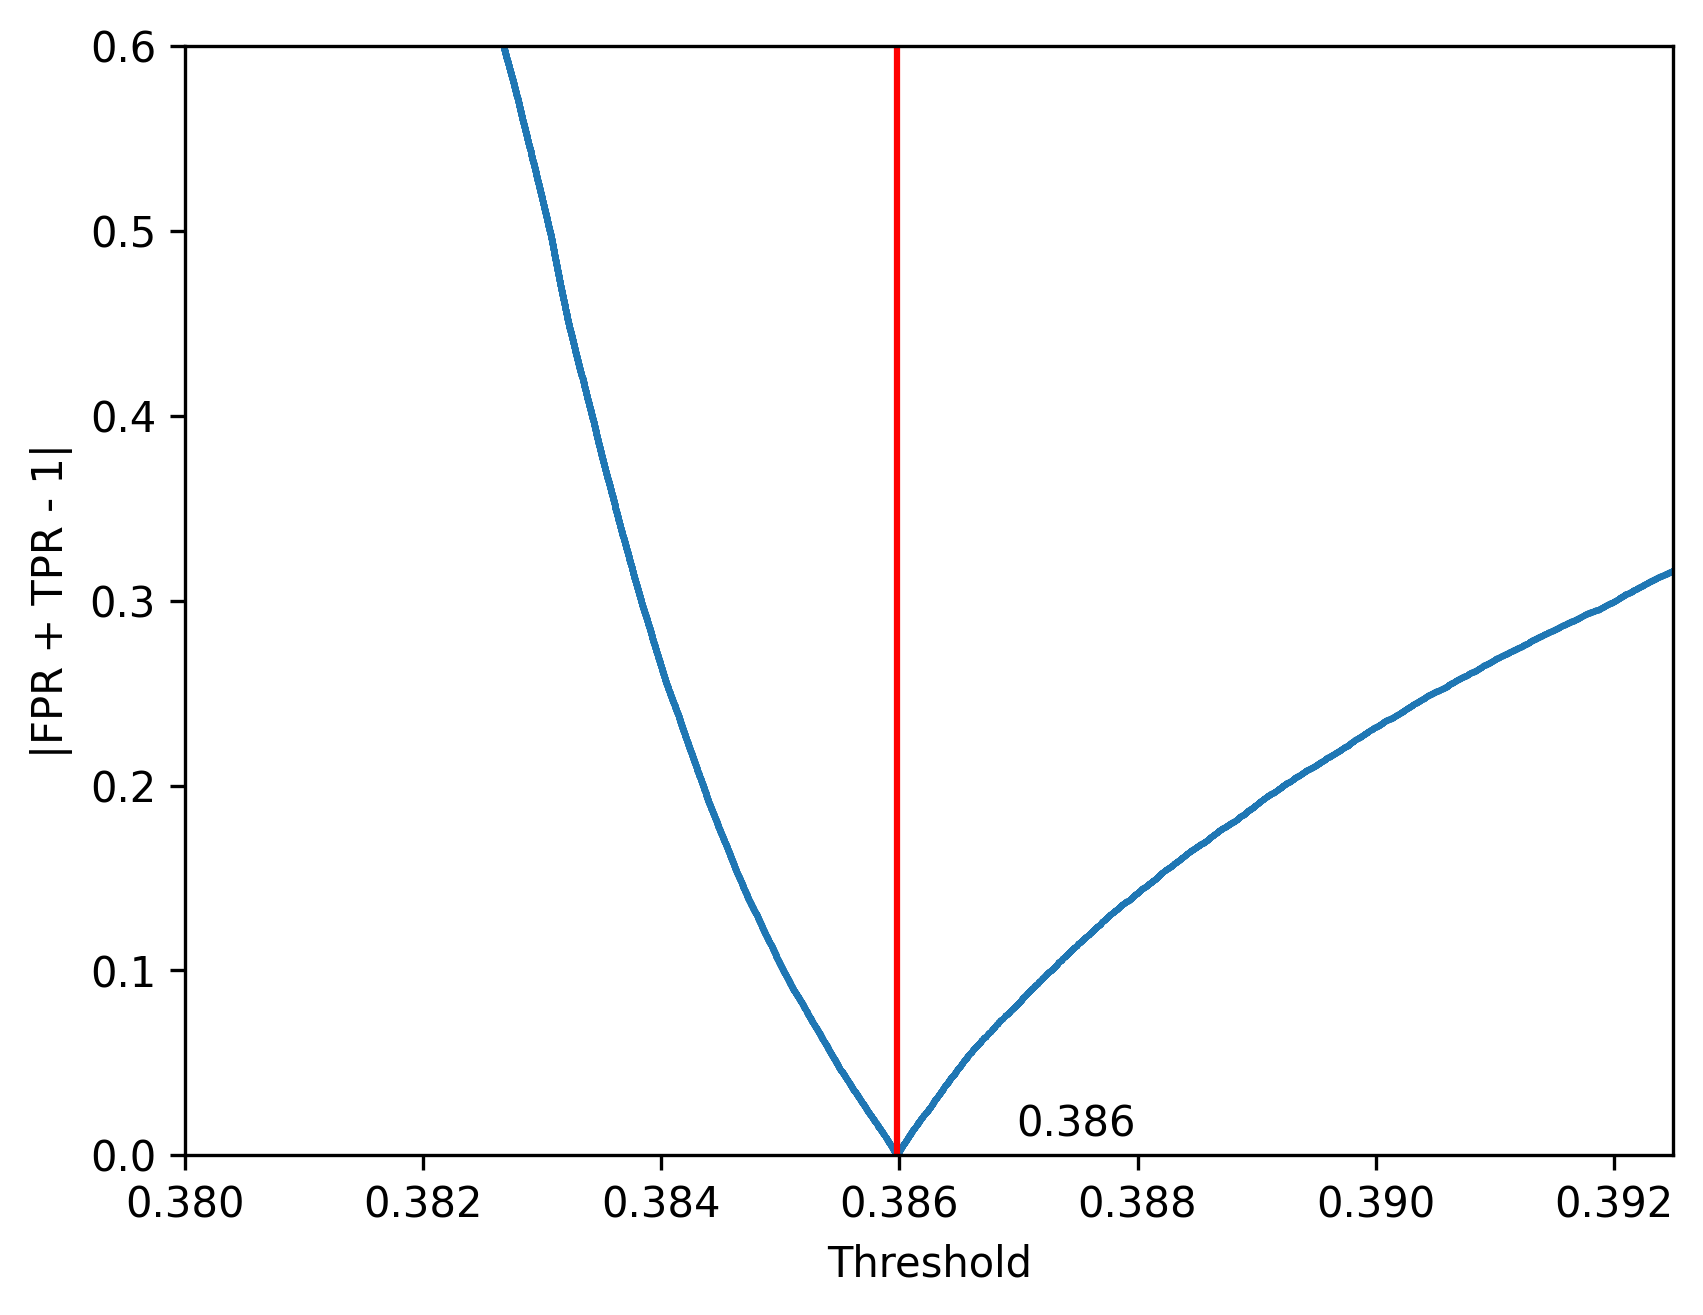

In [20]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_train, drop_intermediate=False)

# Create a new figure with a dpi of 300
plt.figure(dpi=300)

plt.scatter(thresholds, np.abs(fpr + tpr - 1), s=0.1)
plt.xlabel("Threshold")

# let x-axis go from 0.384 to 0.3925
plt.xlim([0.38,0.3925])
plt.ylabel("|FPR + TPR - 1|")

# plot the vertical line at the best threshold for FPR + TPR - 1
plt.axvline(x=thresholds[np.argmin(np.abs(fpr + tpr - 1))], color='r')

# plot the exact threshold value for FPR + TPR - 1
plt.text(thresholds[np.argmin(np.abs(fpr + tpr - 1))] + 0.001, 0.01, str(round(thresholds[np.argmin(np.abs(fpr + tpr - 1))], 4)))
plt.ylim([0,0.6])
plt.show()


In [22]:
from sklearn.metrics import f1_score
# Create a list of possible thresholds and f1 scores
thresholds = np.arange(0.386, 0.5, 0.001)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_scores_train > threshold).astype(int)
    score = f1_score(y_train, y_pred)
    f1_scores.append(score)

# Find the threshold that gave the highest f1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_score = np.max(f1_scores)

print(f"Optimal threshold is: {optimal_threshold}")
print(f"Highest F1 score at optimal threshold is: {optimal_score}")

Optimal threshold is: 0.386
Highest F1 score at optimal threshold is: 0.5225853924849866


In [23]:
# Set custom threshold
threshold = optimal_threshold

# Make a prediction using the trained SVM model with the custom threshold applied
y_pred = (y_pred_proba_test[:,1] > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3845012626262626


In [24]:
print(sum(y_pred))

15394


In [25]:
print(len(y_pred))

31680


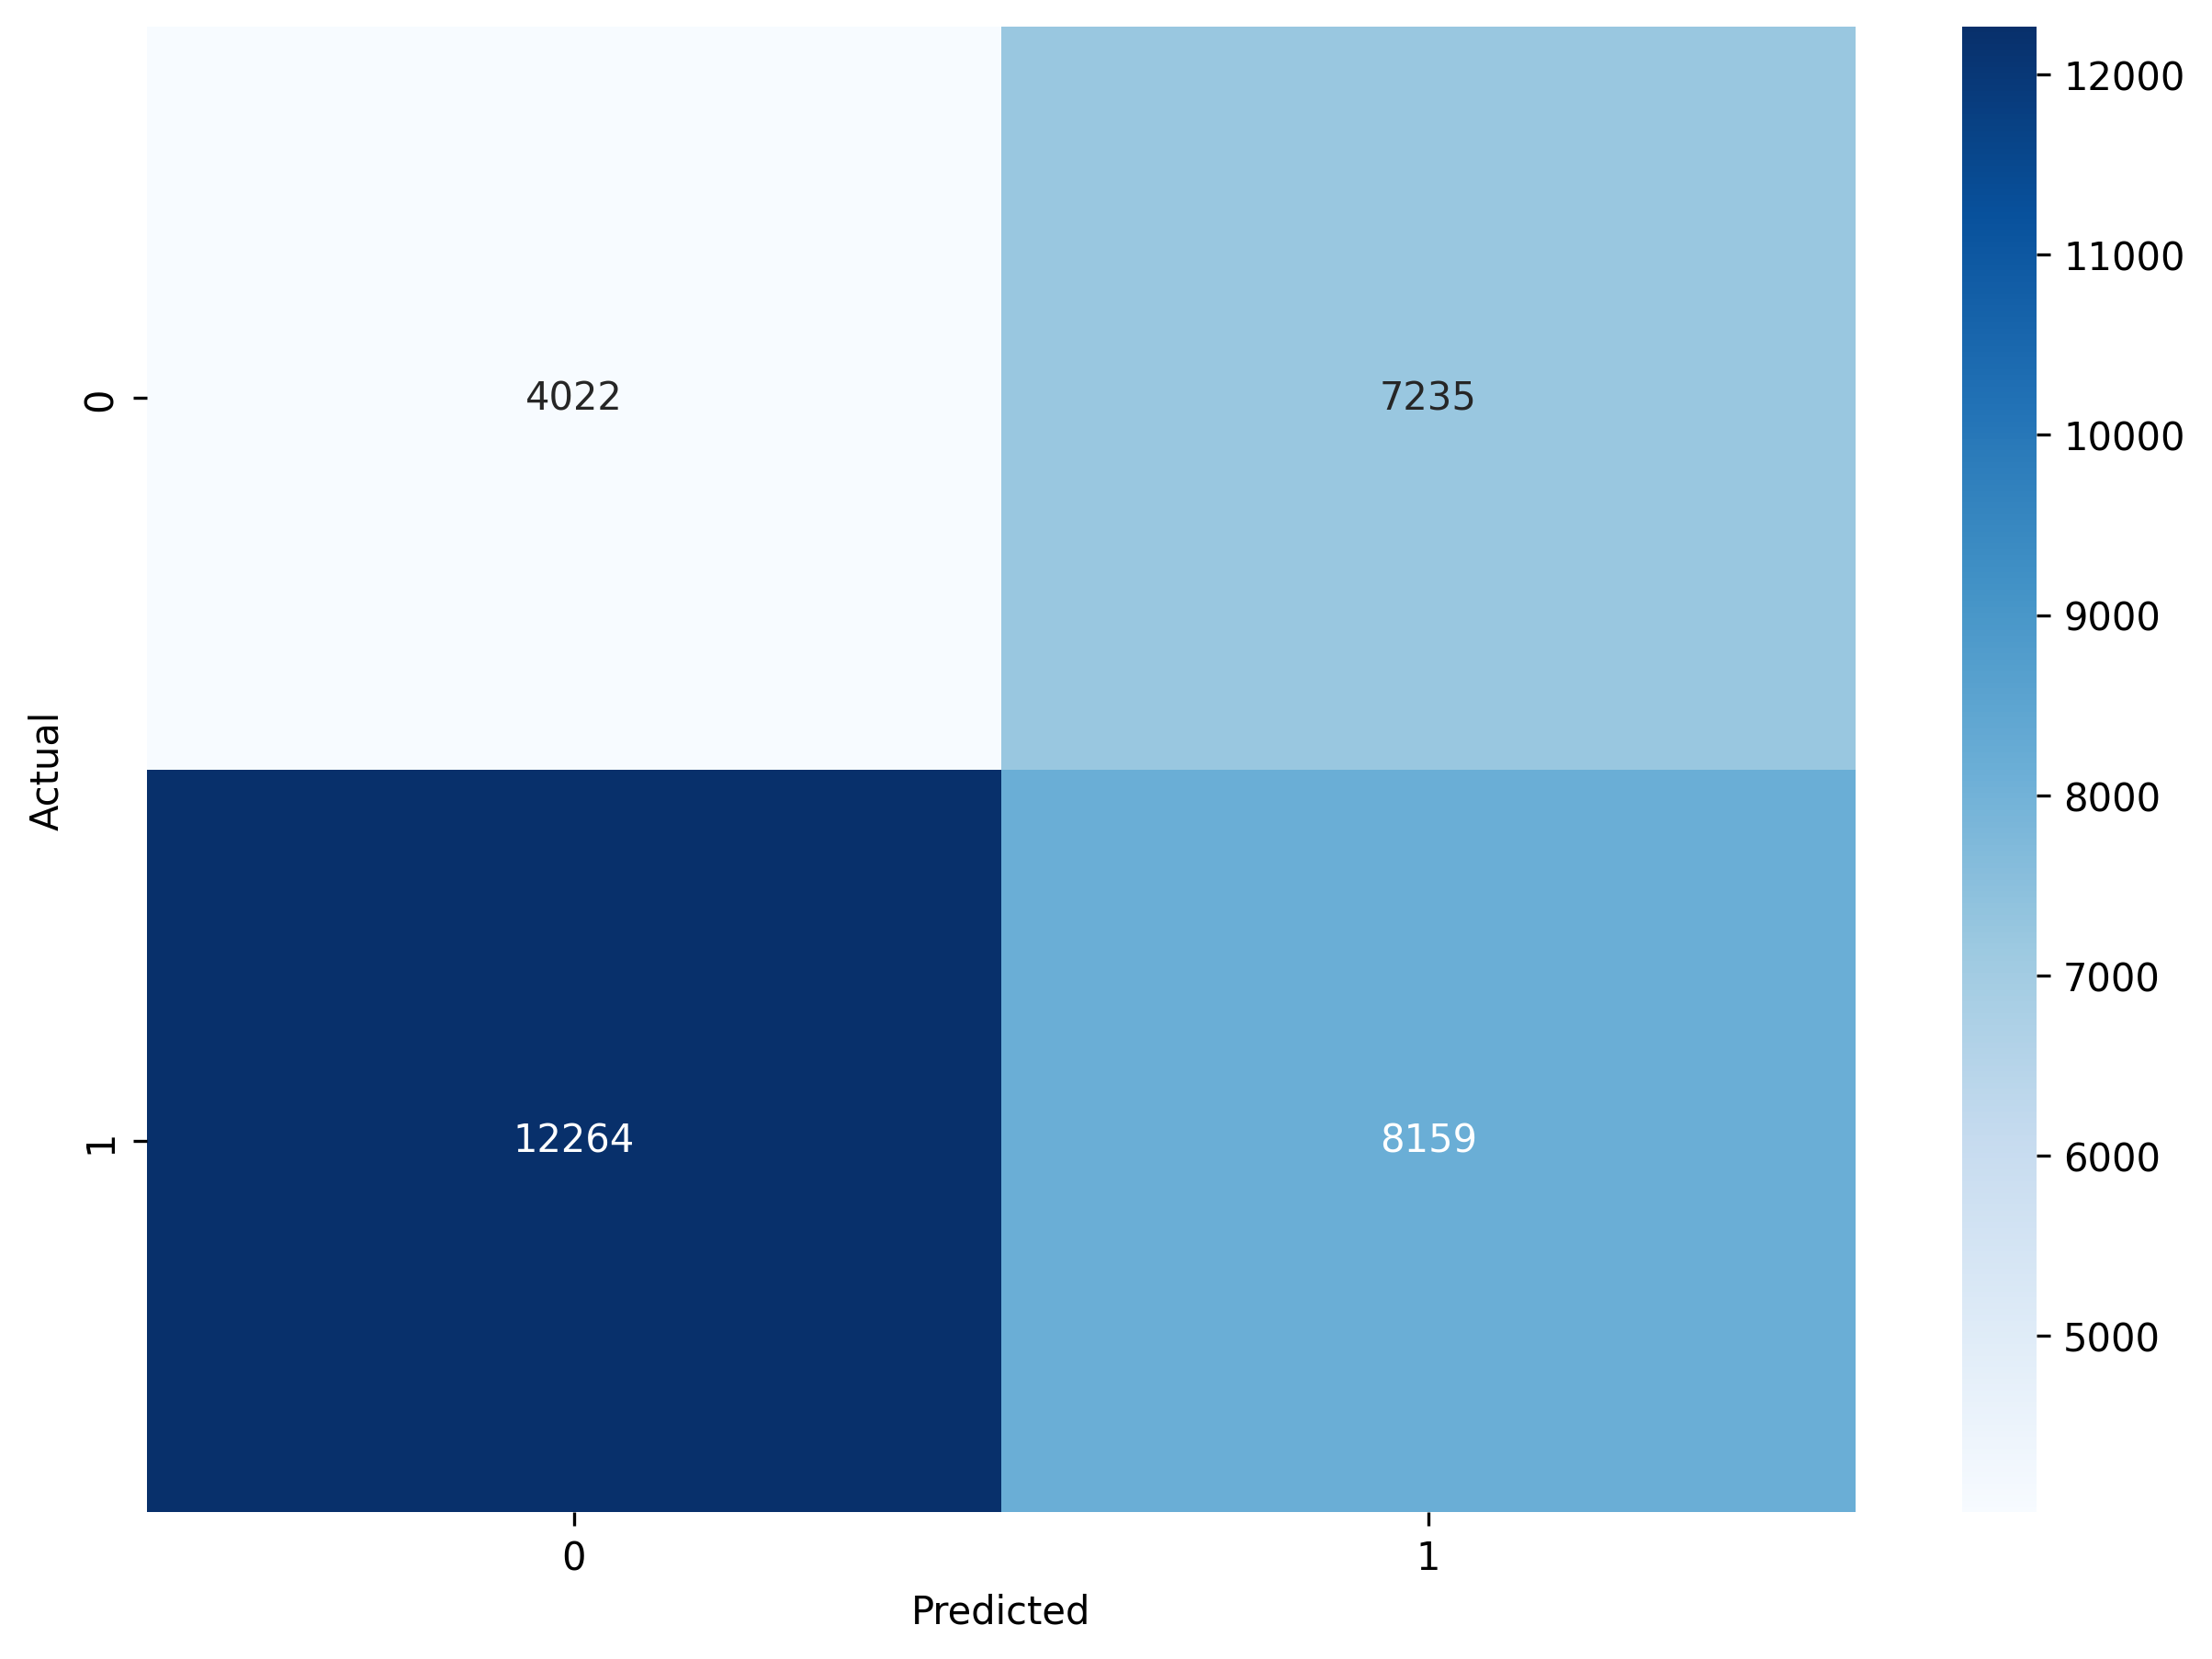

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(10,7),dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
ticker_name_df = pd.read_csv('SP500_stock_prices.csv', delimiter=',')
# Make date column the index
ticker_name_df = ticker_name_df.set_index('Date')
# only display year, month and day in index
ticker_name_df.index = pd.to_datetime(ticker_name_df.index).date
# only keep the Ticker
ticker_name_df = ticker_name_df[['Ticker']]
# drop duplicates
ticker_name_df = ticker_name_df.drop_duplicates()
# remove the index
ticker_name_df = ticker_name_df.reset_index(drop=True)
ticker_name_df

,Ticker
0,MMM
1,AOS
2,ABT
3,ABBV
4,ACN
...,...
492,YUM
493,ZBRA
494,ZBH
495,ZION


In [28]:
test['Ticker'] = test['Ticker'].astype('category')
#  make y_pred and y_pred_proba a column in the test dataset
test['Prediction'] = y_pred
test['Prediction Probability (0)'] = y_pred_proba_test[:,0]
test['Prediction Probability (1)'] = y_pred_proba_test[:,1]
# only keep columns for ticker, target, and prediction
test = test[['Ticker', 'Target', 'Prediction', 'Prediction Probability (1)', 'Prediction Probability (0)', 'Return']]
# make the ticker column a name again

C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1012690241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Ticker'] = test['Ticker'].astype('category')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1012690241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = y_pred
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1012690241.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [29]:
import cvxpy as cp
import pandas as pd

def calculate_optimal_weights(test, date):
    # only keep the rows of a specific date
    # make a date be of type datetime
    date = pd.to_datetime(date)
    
    # make a new dataframe where return is the index and each column is a ticker
    return_df = test.pivot(columns='Ticker', values='Return')
    # remove stocks that have nan values in the return column
    return_df = return_df.dropna(axis=1)
    # for each ticker only keep the row of the input date
    test = test.groupby('Ticker').apply(lambda x: x.loc[x.index == date])
    test['Ticker'] = test['Ticker'].cat.remove_unused_categories()
    
    # ensure that the tickers in test are the same as the tickers in return_df
    test = test[test['Ticker'].isin(return_df.columns)]

    return_deviation = return_df.iloc[0:62]
    
    # Calculate the covariance matrix
    cov_matrix = return_deviation.cov()
    # Force the covariance matrix to be symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Number of stocks
    n = len(test['Ticker'])
    # Weights for each stock in the portfolio
    w = cp.Variable(n)
    # Objective is to minimize portfolio variance
    risk = cp.quad_form(w, cov_matrix)
    
    
    objective = cp.Minimize(risk)
   # Get the number of stocks
    n_stocks = len(test["Prediction"])

    # Get the indices of the 10 tickers with the highest predicted probabilities
    top_10_indices = test["Prediction"].nlargest(10).index

    # Constraints:
    # - weights must sum to 1
    # - only consider stocks where the SVM prediction is 1 (price will increase)
    # - expected portfolio return must be at least a certain value (e.g., 0.01)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w[test["Prediction"] == 0] == 0,
    ]

    # Only keep the 10 stocks with the highest prediction probability of increasing in price
    # Set weights for non-top 10 tickers to zero
    constraints.extend([w[i] == 0 for i in range(n_stocks) if i not in top_10_indices])

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()



    # Get the optimal weights
    optimal_weights = w.value
    if optimal_weights is None:
        optimal_weights = np.zeros(n)
    # Create a dataframe with the optimal weights
    optimal_weights_df = pd.DataFrame(optimal_weights, index=test["Ticker"])
    # add the ticker names to the dataframe
    optimal_weights_df = optimal_weights_df.join(ticker_name_df)
    # remove the index
    optimal_weights_df = optimal_weights_df.reset_index(drop=True)
    # make the ticker the index
    optimal_weights_df = optimal_weights_df.set_index('Ticker')
    # make the column name weights
    optimal_weights_df.columns = ['Weights']

    # Sort the dataframe by the optimal weights
    optimal_weights_df = optimal_weights_df.sort_values(by=['Weights'], ascending=False)

    # Only keep the top 10 stocks and their weights, but exclude the most weighted stock
    #optimal_weights_df = optimal_weights_df.iloc[1:11]
    optimal_weights_df = optimal_weights_df.head(10)
    # normalize the weights so that they sum to 1
    optimal_weights_df['Weights'] = optimal_weights_df['Weights'] / optimal_weights_df['Weights'].sum()
    return round(optimal_weights_df,3)

In [30]:

import pandas as pd

def calculate_return(ticker, df, start_date):
    # Convert string dates to datetime
    start_date = pd.to_datetime(start_date)
    # Calculate the end date as start date + 63 trading days
    end_date = start_date + pd.tseries.offsets.BDay(63)
    # remove nan values from df
    df = df.dropna(axis=1)
    
    # Filter the dataframe for the given ticker
    df_ticker = df[df['Ticker'] == ticker]
    # Filter data between start and end dates
    mask = (df_ticker.index >= start_date) & (df_ticker.index <= end_date)
    df_ticker = df_ticker.loc[mask]
    
    # Get the opening price at the start and end dates
    start_price = df_ticker['Open'].iloc[0]
    end_price = df_ticker['Open'].iloc[-1]

    # Calculate the return
    return_percent = ((end_price - start_price) / start_price) * 100

    return round(return_percent,2)

In [31]:
def calculate_average_return(test, initial_df):
    # Initialize returns list
    returns_list = []

    # For each date in the test set
    for date in test.index.unique():
        # Calculate the optimal weights for the portfolio
        optimal_weights_df = calculate_optimal_weights(test, date)

        # Calculate the return of the portfolio
        return_list = []
        for ticker in optimal_weights_df.index:
            if optimal_weights_df.loc[ticker]['Weights'] > 0:
                # Calculate the return of the stock
                return_list.append(calculate_return(ticker, initial_df_test, date))

        # Calculate the return of the portfolio
        portfolio_return = 0
        for i in range(len(return_list)):
            portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']

        # Append the return to the list
        returns_list.append(round(portfolio_return,1))
    
    # Calculate and return the average portfolio return
    return np.mean(returns_list)

In [275]:
# for each date in the test set calculate the return of the portfolio
# empty list to store the returns
returns_list = []
# for each date in the test set
for date in test.index.unique():
    # calculate the optimal weights for the portfolio
    optimal_weights_df = calculate_optimal_weights(test, date)
    #print(optimal_weights_df)
    # calculate the return of the portfolio
    # for the top 10 weighted stocks in the portfolio calculate their return
    # empty list to store the returns
    return_list = []
    # for each stock in the portfolio
    for ticker in optimal_weights_df.index:
        if optimal_weights_df.loc[ticker]['Weights'] > 0:
            # calculate the return of the stock
            return_list.append(calculate_return(ticker, initial_df_test, date))
    # Calculate the return of the portfolio
    portfolio_return = 0
    for i in range(len(return_list)):
        portfolio_return += return_list[i] * optimal_weights_df.iloc[i]['Weights']
    # append the return to the list
    returns_list.append(round(portfolio_return,1))

In [128]:
# calculate the number of unique tickers in all the optimal portfolios
unique_tickers = []
for date in test.index.unique():
    optimal_weights_df = calculate_optimal_weights(test, date)
    for ticker in optimal_weights_df.index:
        if optimal_weights_df.loc[ticker]['Weights'] > 0:
            unique_tickers.append(ticker)
# remove duplicates
unique_tickers = list(set(unique_tickers))


# print the length of the list
print("Number of unique tickers in the optimal portfolios: {}".format(len(unique_tickers)))

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Number of unique tickers in the optimal portfolios: 17


In [130]:
# order the list alphabetically
unique_tickers.sort()
unique_tickers

['AAP',
 'ABBV',
 'ABT',
 'ADBE',
 'ADM',
 'AES',
 'AFL',
 'AKAM',
 'ALGN',
 'ALK',
 'ALL',
 'AMCR',
 'AMZN',
 'AOS',
 'GOOG',
 'GOOGL',
 'MO']

In [35]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3-month Returns (%)']
returns_df

,SVM Portfolio 3-month Returns (%)
2019-10-01,11.6
2019-10-02,14.9
2019-10-03,16.0
2019-10-04,14.9
2019-10-07,14.9
...,...
2019-12-24,-29.1
2019-12-26,-26.8
2019-12-27,-27.5
2019-12-30,-22.4


In [36]:
# average return of the portfolio
print(f"Average return of the portfolio: {np.mean(returns_list)}")
# print the standard deviation of the returns
print(f"Standard deviation of the returns: {np.std(returns_list)}")
# print number of days the portfolio had a positive return
print(f"Number of days the portfolio had a positive return: {len([i for i in returns_list if i > 0])}")
print(f"Number of days the portfolio had a negative return: {len([i for i in returns_list if i < 0])}")

Average return of the portfolio: -0.16562500000000058
Standard deviation of the returns: 14.056917989352252
Number of days the portfolio had a positive return: 42
Number of days the portfolio had a negative return: 22


In [170]:
# read in the csv file for svm_portfolio_returns_gamma=10
svm_portfolio_returns_gamma_10 = pd.read_csv('svm_portfolio_returns_gamma_10.csv',index_col=0)
svm_portfolio_returns_gamma_10


,SVM Portfolio 3-month Returns (%) gamma = 10
2019-10-01,7.0
2019-10-02,9.6
2019-10-03,9.0
2019-10-04,11.0
2019-10-07,11.2
...,...
2019-12-24,-22.8
2019-12-26,-28.6
2019-12-27,-24.8
2019-12-30,-27.2


In [173]:
# perform wilcoxon signed rank test on the two portfolios to determine if they are significantly different
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(returns_df,svm_portfolio_returns_gamma_10)
print('Statistics=%.3f, p=%.7f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('SVM (gamma = default) vs SVM (gamma = 10): Same distribution (fail to reject H0)')
else:
    print('SVM (gamma = default) vs SVM (gamma = 10): Different distribution (reject H0)')

Statistics=594.000, p=0.0028568
SVM (gamma = default) vs SVM (gamma = 10): Different distribution (reject H0)


In [175]:
# calculate the average return of the two portfolios and their standard deviation
svm_portfolio_returns_gamma_10_mean = np.mean(svm_portfolio_returns_gamma_10)
svm_portfolio_returns_gamma_10_std = np.std(svm_portfolio_returns_gamma_10)
print(f"Average return of the SVM portfolio (gamma = 10): {svm_portfolio_returns_gamma_10_mean}")
print(f"Standard deviation of the SVM portfolio (gamma = 10): {svm_portfolio_returns_gamma_10_std}")


returns_df_mean = np.mean(returns_df)
returns_df_std = np.std(returns_df)
print(f"Average return of the SVM portfolio (gamma = default): {returns_df_mean}")
print(f"Standard deviation of the SVM portfolio (gamma = default): {returns_df_std}")



Average return of the SVM portfolio (gamma = 10): SVM Portfolio 3-month Returns (%) gamma = 10   -1.514063
dtype: float64
Standard deviation of the SVM portfolio (gamma = 10): SVM Portfolio 3-month Returns (%) gamma = 10    12.367408
dtype: float64
Average return of the SVM portfolio (gamma = default): SVM Portfolio 3-month Returns (%)   -0.195313
dtype: float64
Standard deviation of the SVM portfolio (gamma = default): SVM Portfolio 3-month Returns (%)    14.240725
dtype: float64


In [219]:
# Comparing the SVM portfolio with its SVM PE-Ratio counterpart
# read in the csv file for svm_portfolio_returns_pe
svm_portfolio_returns_pe_ratio = pd.read_csv('svm_portfolio_returns_pe.csv',index_col=0)
svm_portfolio_returns_pe_ratio

,SVM Portfolio 3-month Returns (%) with PE-Ratio
2019-10-01,15.8
2019-10-02,14.8
2019-10-03,16.0
2019-10-04,14.9
2019-10-07,14.5
...,...
2019-12-24,-20.6
2019-12-26,-26.8
2019-12-27,-28.2
2019-12-30,-22.4


In [221]:
# perform wilcoxon signed rank test on the two portfolios to determine if they are significantly different
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(returns_df,svm_portfolio_returns_pe_ratio)
print('Statistics=%.3f, p=%.7f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('SVM vs SVM with PE-Ratio Included: Same distribution (fail to reject H0)')
else:
    print('SVM vs SVM with PE-Ratio Included: Different distribution (reject H0)')

Statistics=857.000, p=0.6693685
SVM vs SVM with PE-Ratio Included: Same distribution (fail to reject H0)


In [222]:
# calculate the average return of the two portfolios and their standard deviation
svm_portfolio_returns_pe_mean = np.mean(svm_portfolio_returns_pe_ratio)
svm_portfolio_returns_std = np.std(svm_portfolio_returns_pe_ratio)
print(f"Average return of the SVM portfolio with PE-Ratio included: {svm_portfolio_returns_pe_mean}")
print(f"Standard deviation of the SVM portfolio with PE-Ratio included: {svm_portfolio_returns_std}")


returns_df_mean = np.mean(returns_df)
returns_df_std = np.std(returns_df)
print(f"Average return of the SVM portfolio: {returns_df_mean}")
print(f"Standard deviation of the SVM portfolio: {returns_df_std}")


Average return of the SVM portfolio with PE-Ratio included: SVM Portfolio 3-month Returns (%) with PE-Ratio    0.073437
dtype: float64
Standard deviation of the SVM portfolio with PE-Ratio included: SVM Portfolio 3-month Returns (%) with PE-Ratio    13.551179
dtype: float64
Average return of the SVM portfolio: SVM Portfolio 3-month Returns (%)   -0.195313
dtype: float64
Standard deviation of the SVM portfolio: SVM Portfolio 3-month Returns (%)    14.240725
dtype: float64


In [379]:
# Make a dataframe with the returns and dates
returns_df = pd.DataFrame(returns_list, index=test.index.unique())
# make the column name returns
returns_df.columns = ['SVM Portfolio 3 Month Returns (%)']

returns_df

,SVM Portfolio 3 Month Returns (%)
2019-10-01,11.6
2019-10-02,14.9
2019-10-03,16.0
2019-10-04,14.9
2019-10-07,14.9
...,...
2019-12-24,-29.1
2019-12-26,-26.8
2019-12-27,-27.5
2019-12-30,-22.4


In [363]:
# compare their average returns and standard deviations
svm_portfolio_returns_much_data_mean = np.mean(svm_portfolio_returns_much_data)
svm_portfolio_returns_much_data_std = np.std(svm_portfolio_returns_much_data)
print(f"Average return of the SVM portfolio with more data: {svm_portfolio_returns_much_data_mean}")
print(f"Standard deviation of the SVM portfolio with more data: {svm_portfolio_returns_much_data_std}")

returns_df_mean = np.mean(returns_df)
returns_df_std = np.std(returns_df)
print(f"Average return of the SVM portfolio: {returns_df_mean}")
print(f"Standard deviation of the SVM portfolio: {returns_df_std}")


Average return of the SVM portfolio with more data: SVM Portfolio 3-month Returns (%) with lots of Data    0.009524
dtype: float64
Standard deviation of the SVM portfolio with more data: SVM Portfolio 3-month Returns (%) with lots of Data    13.312325
dtype: float64
Average return of the SVM portfolio: SVM Portfolio 3 Month Returns (%)    0.198413
dtype: float64
Standard deviation of the SVM portfolio: SVM Portfolio 3 Month Returns (%)    13.865493
dtype: float64


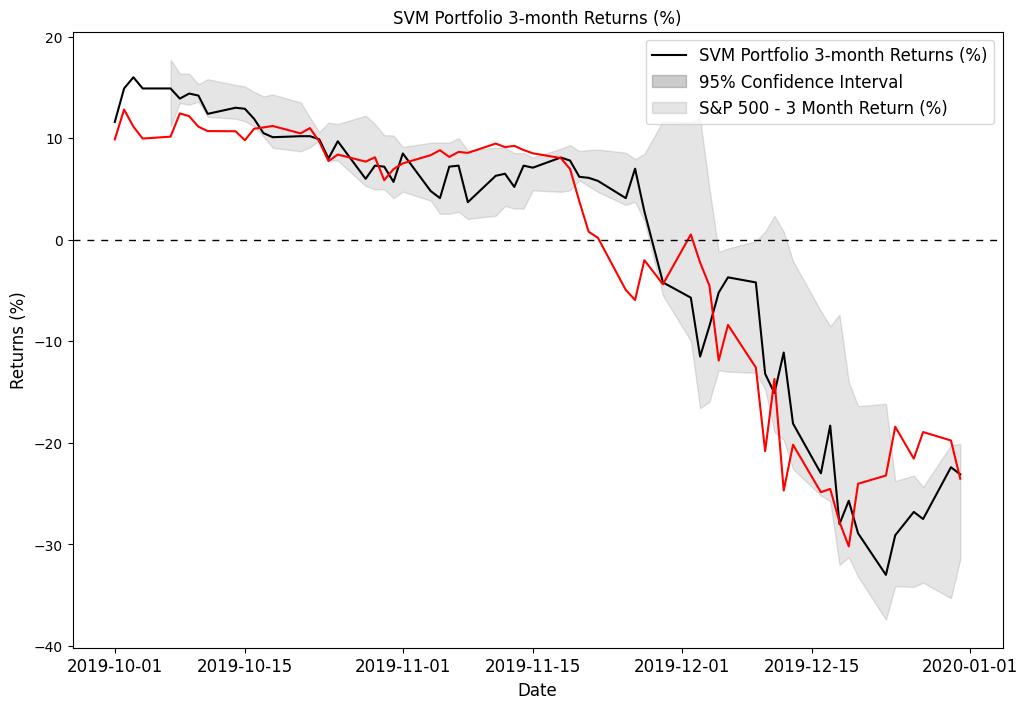

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
moving_average = returns_df.rolling(window=5).mean()
moving_variance = returns_df.rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=returns_df, x=returns_df.index, y='SVM Portfolio 3-month Returns (%)', color = 'black')
# make confidence interval shaded area
plt.fill_between(moving_variance.index, moving_average['SVM Portfolio 3-month Returns (%)'] - 1.96 * moving_variance['SVM Portfolio 3-month Returns (%)'], moving_average['SVM Portfolio 3-month Returns (%)'] + 1.96 * moving_variance['SVM Portfolio 3-month Returns (%)'], alpha=0.1, color='black')
# plot the S%P 500 returns
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)', color = 'red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5)) 
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
# plot legend in the upper right corner for returns,  95% confidence interval, and S&P 500 returns
# ensure that the legend has the right representation of the SP500 returns
plt.legend(['SVM Portfolio 3-month Returns (%)', '95% Confidence Interval', 'S&P 500 - 3 Month Return (%)'], loc='upper right', fontsize='large')

plt.show()

In [43]:
# average return
print('Average return:', round(returns_df.mean()[0],3))

Average return: -0.166


In [118]:
# show the 10 days with the most return
returns_df.sort_values(by=['SVM Portfolio 3 Month Returns (%)'], ascending=False).head(10)


,SVM Portfolio 3 Month Returns (%)
2019-10-03,16.0
2019-10-02,14.9
2019-10-04,14.9
2019-10-07,14.9
2019-10-09,14.4
2019-10-10,14.2
2019-10-08,13.9
2019-10-14,13.0
2019-10-15,12.9
2019-10-11,12.4


In [117]:
# show the 10 days with the least return
returns_df.sort_values(by=['SVM Portfolio 3 Month Returns (%)'], ascending=True).head(10)

,SVM Portfolio 3 Month Returns (%)
2019-12-23,-33.0
2019-12-24,-29.1
2019-12-20,-28.9
2019-12-18,-28.0
2019-12-27,-27.5
2019-12-26,-26.8
2019-12-19,-25.7
2019-12-31,-23.1
2019-12-16,-23.0
2019-12-30,-22.4


## S&P 500 Returns in the same time period

In [380]:
import yfinance as yf
from pandas_datareader import data as pdr
# This line is needed to fix a problem with pandas_datareader
yf.pdr_override()

start_date = '2019-10-01'
end_date = '2020-04-02'
# 
# Get data from Yahoo Finance
sp500 = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
# we are only interested in the open price
sp500 = sp500['Close']
# Transform it into a dataframe
sp500_returns = pd.DataFrame(sp500)
# Make 'S&P 500 Index Price' the column header
sp500_returns = sp500_returns.rename(columns={'Close': 'S&P 500 Index Price'})
# Calculate the 3 month return for each day
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 Index Price'].pct_change(periods=63).shift(-63)
# calculating all 3-month return values by 100 to obtain percent
sp500_returns['S&P 500 - 3 Month Return (%)'] = sp500_returns['S&P 500 - 3 Month Return (%)'] * 100
sp500_returns.round(2)
# remove the S&P 500 Index Price column
sp500_returns = sp500_returns.drop(columns=['S&P 500 Index Price'])
# removing all rows with NaN values (The last 62 days, since they don't have data for 3 months into the future)
sp500_returns = sp500_returns.dropna()
sp500_returns

[*********************100%***********************]  1 of 1 completed


,S&P 500 - 3 Month Return (%)
Date,
2019-10-01,9.881134
2019-10-02,12.821675
2019-10-03,11.139177
2019-10-04,9.968463
2019-10-07,10.153495
...,...
2019-12-24,-18.406450
2019-12-26,-21.557388
2019-12-27,-18.931059


In [47]:
# Find mean of sp 500 returns as well as standard deviation and how many days where positive and negative
sp500_returns_mean = np.mean(sp500_returns)
sp500_returns_std = np.std(sp500_returns)
sp500_returns_positive = sp500_returns[sp500_returns['S&P 500 - 3 Month Return (%)'] > 0]
sp500_returns_negative = sp500_returns[sp500_returns['S&P 500 - 3 Month Return (%)'] < 0]
print('S&P 500 Mean Return:', round(sp500_returns_mean[0],3))
print('S&P 500 Standard Deviation:', round(sp500_returns_std[0],3))
print('S&P 500 Positive Days:', len(sp500_returns_positive))
print('S&P 500 Negative Days:', len(sp500_returns_negative))


S&P 500 Mean Return: -0.741
S&P 500 Standard Deviation: 13.424
S&P 500 Positive Days: 40
S&P 500 Negative Days: 24


In [48]:
# Find lowest return and highest return with their dates
print('S&P 500 Lowest Return:', round(sp500_returns.min()[0],3), 'on', sp500_returns.idxmin()[0])
print('S&P 500 Highest Return:', round(sp500_returns.max()[0],3), 'on', sp500_returns.idxmax()[0])

S&P 500 Lowest Return: -30.198 on 2019-12-19 00:00:00
S&P 500 Highest Return: 12.822 on 2019-10-02 00:00:00


__Random Monkey__

In [381]:
# add the returns of random monkey model as a new column
random_monkey_returns = pd.read_csv('random_monkey_portfolio_returns.csv', index_col=0)
# make random monkey index as datetime
random_monkey_returns.index = pd.to_datetime(random_monkey_returns.index)

In [382]:
# Combine the returns of the portfolio and the S&P 500
combined_returns = pd.concat([returns_df, sp500_returns], axis='columns', join='inner')
combined_returns.round(1)
# add a new column that shows the Random Monkey returns
combined_returns['Random Monkey - 3 Month Returns (%)'] = random_monkey_returns['Random Monkey - 3 Month Return (%)'].copy()
round(combined_returns,1)
# remove the last date
combined_returns = combined_returns[:-1]
combined_returns

,SVM Portfolio 3 Month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey - 3 Month Returns (%)
2019-10-01,11.6,9.881134,4.6
2019-10-02,14.9,12.821675,19.1
2019-10-03,16.0,11.139177,14.4
2019-10-04,14.9,9.968463,9.0
2019-10-07,14.9,10.153495,9.8
...,...,...,...
2019-12-23,-33.0,-23.214877,-33.4
2019-12-24,-29.1,-18.406450,-23.7
2019-12-26,-26.8,-21.557388,-26.8
2019-12-27,-27.5,-18.931059,-18.4


In [249]:
# number of positive and negative days for the SVM portfolio
svm_positive = combined_returns[combined_returns['SVM Portfolio 3 Month Returns (%)'] > 0]
svm_negative = combined_returns[combined_returns['SVM Portfolio 3 Month Returns (%)'] < 0]
print('SVM Portfolio Positive Days:', len(svm_positive))
print('SVM Portfolio Negative Days:', len(svm_negative))


SVM Portfolio Positive Days: 42
SVM Portfolio Negative Days: 21


In [251]:
# number of positive and negative days for the Random Monkey portfolio
random_monkey_positive = combined_returns[combined_returns['Random Monkey - 3 Month Returns (%)'] > 0]
random_monkey_negative = combined_returns[combined_returns['Random Monkey - 3 Month Returns (%)'] < 0]
print('Random Monkey Positive Days:', len(random_monkey_positive))
print('Random Monkey Negative Days:', len(random_monkey_negative))


Random Monkey Positive Days: 38
Random Monkey Negative Days: 25


In [254]:
# positive and negative days for the S&P 500 
sp500_positive = combined_returns[combined_returns['S&P 500 - 3 Month Return (%)'] > 0]
sp500_negative = combined_returns[combined_returns['S&P 500 - 3 Month Return (%)'] < 0]
print('S&P 500 Positive Days:', len(sp500_positive))
print('S&P 500 Negative Days:', len(sp500_negative))

S&P 500 Positive Days: 40
S&P 500 Negative Days: 23


In [273]:
# calculate the average return for each portfolio and print it
svm_average_return = combined_returns['SVM Portfolio 3 Month Returns (%)'].mean()
random_monkey_average_return = combined_returns['Random Monkey - 3 Month Returns (%)'].mean()
sp500_average_return = combined_returns['S&P 500 - 3 Month Return (%)'].mean()
print('SVM Portfolio Average Return:', round(svm_average_return,3))
print('Random Monkey Average Return:', round(random_monkey_average_return,3))
print('S&P 500 Average Return:', round(sp500_average_return,3))
# calculate the standard deviation for each portfolio and print it
svm_std = combined_returns['SVM Portfolio 3 Month Returns (%)'].std()
random_monkey_std = combined_returns['Random Monkey - 3 Month Returns (%)'].std()
sp500_std = combined_returns['S&P 500 - 3 Month Return (%)'].std()
print('SVM Portfolio Standard Deviation:', round(svm_std,3))
print('Random Monkey Standard Deviation:', round(random_monkey_std,3))
print('S&P 500 Standard Deviation:', round(sp500_std,3))
# median return for each portfolio
svm_median = combined_returns['SVM Portfolio 3 Month Returns (%)'].median()
random_monkey_median = combined_returns['Random Monkey - 3 Month Returns (%)'].median()
sp500_median = combined_returns['S&P 500 - 3 Month Return (%)'].median()
print('SVM Portfolio Median Return:', round(svm_median,3))
print('Random Monkey Median Return:', round(random_monkey_median,3))
print('S&P 500 Median Return:', round(sp500_median,3))



SVM Portfolio Average Return: 0.198
Random Monkey Average Return: -2.511
S&P 500 Average Return: -0.38
SVM Portfolio Standard Deviation: 13.977
Random Monkey Standard Deviation: 14.935
S&P 500 Standard Deviation: 13.324
SVM Portfolio Median Return: 6.2
Random Monkey Median Return: 4.3
S&P 500 Median Return: 7.698


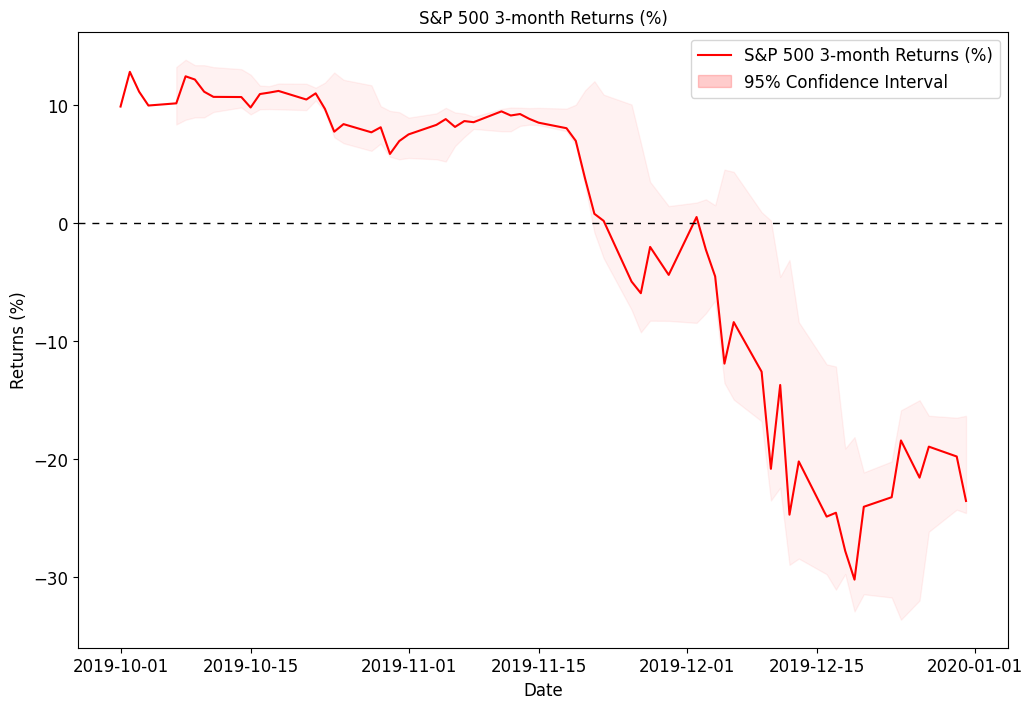

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the S&P 500 returns
# moving average
combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).mean()
# moving standard deviation
combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'] = combined_returns['S&P 500 - 3 Month Return (%)'].rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)', color = 'red')
# # include moving average line
# sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5))
# include shaded area for the moving average confidence interval
plt.fill_between(combined_returns.index, combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] - 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], combined_returns['S&P 500 - 3 Month Return (%) - Moving Average'] + 1.96 * combined_returns['S&P 500 - 3 Month Return (%) - Moving Standard Deviation'], color = 'red', alpha=0.05)
plt.title('S&P 500 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['S&P 500 3-month Returns (%)', '95% Confidence Interval'], loc='upper right', fontsize='large')
plt.show()

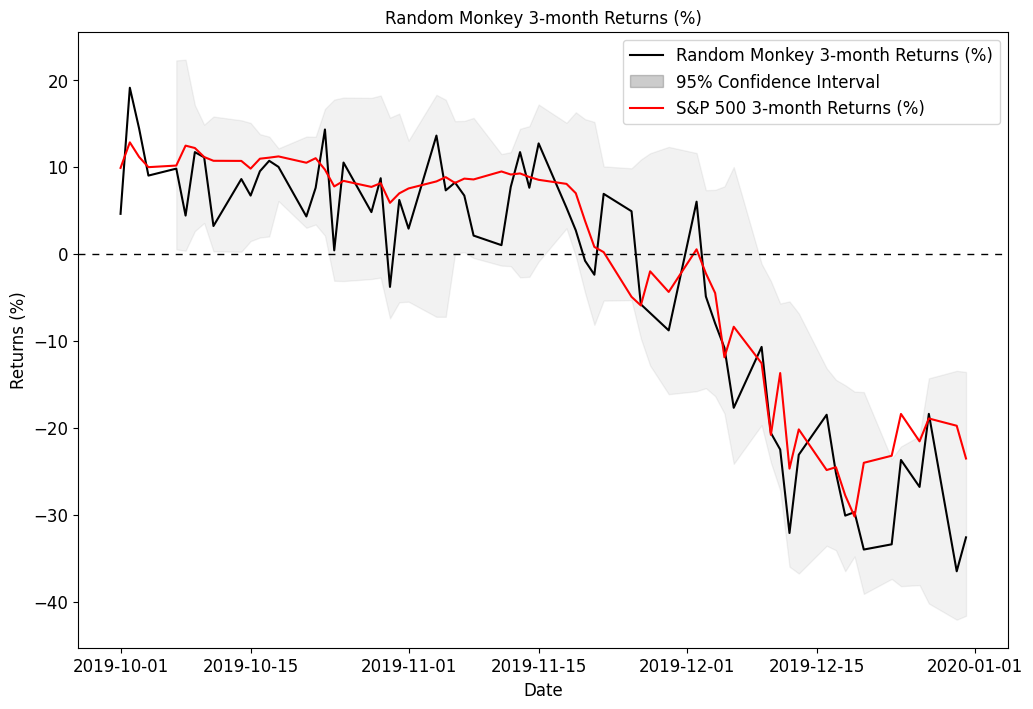

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the Random Monkey returns
# moving average
combined_returns['Random Monkey - 3 Month Returns (%) - Moving Average'] = combined_returns['Random Monkey - 3 Month Returns (%)'].rolling(window=5).mean()
# moving standard deviation
combined_returns['Random Monkey - 3 Month Returns (%) - Moving Standard Deviation'] = combined_returns['Random Monkey - 3 Month Returns (%)'].rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=combined_returns, x=combined_returns.index, y='Random Monkey - 3 Month Returns (%)', color = 'black')
# include moving average line
#sns.lineplot(data=combined_returns, x=combined_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)', color='red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5)) 

# include shaded area for the moving average confidence interval
plt.fill_between(combined_returns.index, combined_returns['Random Monkey - 3 Month Returns (%) - Moving Average'] - 1.96 * combined_returns['Random Monkey - 3 Month Returns (%) - Moving Standard Deviation'], combined_returns['Random Monkey - 3 Month Returns (%) - Moving Average'] + 1.96 * combined_returns['Random Monkey - 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('Random Monkey 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Random Monkey 3-month Returns (%)', '95% Confidence Interval', 'S&P 500 3-month Returns (%)'], loc='upper right', fontsize='large')

plt.show()

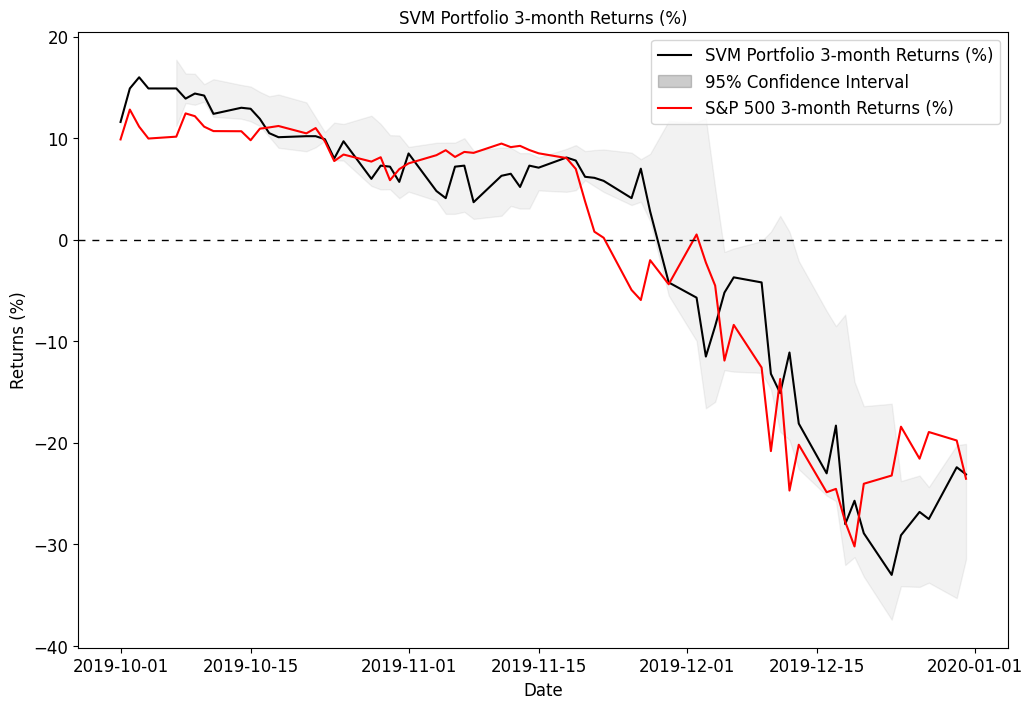

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the SVM Portfolio returns
# moving average
combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Average'] = combined_returns['SVM Portfolio 3 Month Returns (%)'].rolling(window=5).mean()
# moving standard deviation
combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Standard Deviation'] = combined_returns['SVM Portfolio 3 Month Returns (%)'].rolling(window=5).std()
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.lineplot(data=combined_returns, x=combined_returns.index, y='SVM Portfolio 3 Month Returns (%)', color = 'black')
# include moving average line
#sns.lineplot(data=combined_returns, x=combined_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)', color='red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5)) 

# include shaded area for the moving average confidence interval
plt.fill_between(combined_returns.index, combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * combined_returns['SVM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('SVM Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['SVM Portfolio 3-month Returns (%)', '95% Confidence Interval', 'S&P 500 3-month Returns (%)'], loc='upper right', fontsize='large')

plt.show()

__LSTM__

In [327]:
# load LSTM portfolio returns
lstm_portfolio_returns = pd.read_csv('lstm_results_optimal.csv', index_col=0)
lstm_portfolio_returns.index = pd.to_datetime(lstm_portfolio_returns.index)
lstm_portfolio_returns

,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'WBD', 'GNRC', 'TTWO', 'LDOS', 'DXCM'...","[0.36261707, 0.23065443, 0.1231884, 0.06643615...",9.660144,7.526018,20.622943
2019-10-02,"['ALLE', 'SYK', 'AEE', 'XOM', 'CLX', 'WTW', 'D...","[0.41126255, 0.13795632, 0.10488506, 0.0987732...",7.284865,5.454851,11.012420
2019-10-03,"['ALLE', 'FISV', 'PXD', 'EQIX', 'NVR', 'MA', '...","[0.44991924, 0.18431332, 0.13453647, 0.0673366...",10.651261,6.430906,15.039801
2019-10-04,"['ALLE', 'AFL', 'DRI', 'PPL', 'MCD', 'DVA', 'P...","[0.41491002, 0.13931737, 0.1355803, 0.11078452...",9.677986,5.450306,11.941840
2019-10-07,"['ALLE', 'REGN', 'AMD', 'VTR', 'AFL', 'STX', '...","[0.51289064, 0.14837939, 0.0797153, 0.0729335,...",14.351331,7.977626,19.743274
...,...,...,...,...,...
2019-12-23,"['GNRC', 'ROP', 'LYV', 'AJG', 'UNP', 'PARA', '...","[0.5570857, 0.09483502, 0.0923389, 0.07908594,...",7.858184,10.080153,-19.867359
2019-12-24,"['GNRC', 'CPRT', 'ALL', 'WTW', 'ZTS', 'KO', 'I...","[0.30600009, 0.22551406, 0.1077036, 0.10388522...",8.138133,8.535548,-14.084782
2019-12-26,"['ENPH', 'GNRC', 'KEYS', 'AAP', 'CVX', 'IP', '...","[0.30891992, 0.27882486, 0.19770641, 0.0897762...",12.676277,17.765147,-11.501805


In [328]:
# Find the average estimated returns, estimated risk, and actual returns and print them
print('Average Estimated Returns: ', lstm_portfolio_returns['Estimated Return (%)'].mean())
print('Average Estimated Risk: ', lstm_portfolio_returns['Estimated Risk'].mean())
print('Average Actual Returns: ', lstm_portfolio_returns['Actual Returns (%)'].mean())
# Find the number of days with actual positive returns and print it
print('Number of Days with Actual Positive Returns: ', lstm_portfolio_returns[lstm_portfolio_returns['Actual Returns (%)'] > 0]['Actual Returns (%)'].count())
# Find the number of days with actual negative returns and print it
print('Number of Days with Actual Negative Returns: ', lstm_portfolio_returns[lstm_portfolio_returns['Actual Returns (%)'] < 0]['Actual Returns (%)'].count())

# Find the std of the actual returns and print it
print('Standard Deviation of Actual Returns: ', lstm_portfolio_returns['Actual Returns (%)'].std())
# Find the std of the estimated returns and print it
print('Standard Deviation of Estimated Returns: ', lstm_portfolio_returns['Estimated Return (%)'].std())
# find day with the highest actual return and print it 
print('Day with Highest Actual Return: ', lstm_portfolio_returns[lstm_portfolio_returns['Actual Returns (%)'] == lstm_portfolio_returns['Actual Returns (%)'].max()].index[0])
# print the max return
print('Highest Actual Return: ', lstm_portfolio_returns['Actual Returns (%)'].max())
# find day with the lowest actual return and print it
print('Day with Lowest Actual Return: ', lstm_portfolio_returns[lstm_portfolio_returns['Actual Returns (%)'] == lstm_portfolio_returns['Actual Returns (%)'].min()].index[0])
# print the min return
print('Lowest Actual Return: ', lstm_portfolio_returns['Actual Returns (%)'].min())
# calculate median return
print('Median Actual Return: ', lstm_portfolio_returns['Actual Returns (%)'].median())

Average Estimated Returns:  8.796866606776385
Average Estimated Risk:  8.203383927989174
Average Actual Returns:  8.103378964470723
Number of Days with Actual Positive Returns:  45
Number of Days with Actual Negative Returns:  18
Standard Deviation of Actual Returns:  13.080441750778393
Standard Deviation of Estimated Returns:  2.5402418236037603
Day with Highest Actual Return:  2019-11-27 00:00:00
Highest Actual Return:  33.177509518603124
Day with Lowest Actual Return:  2019-12-19 00:00:00
Lowest Actual Return:  -27.639486550096997
Median Actual Return:  12.606141554675036


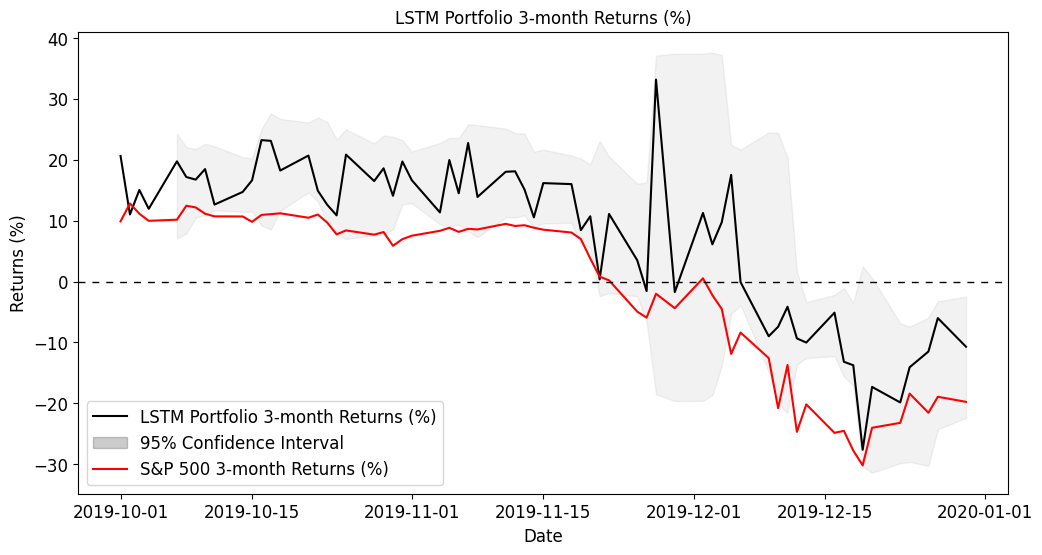

In [329]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the LSTM Portfolio returns
# moving average
lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] = lstm_portfolio_returns['Actual Returns (%)'].rolling(window=5).mean()
# moving standard deviation
lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'] = lstm_portfolio_returns['Actual Returns (%)'].rolling(window=5).std()
plt.figure(figsize=(12,6), facecolor='white', dpi=100)
sns.lineplot(data=lstm_portfolio_returns, x=lstm_portfolio_returns.index, y='Actual Returns (%)', color = 'black')
# include moving average line
#sns.lineplot(data=lstm_portfolio_returns, x=lstm_portfolio_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=combined_returns, x=combined_returns.index, y='S&P 500 - 3 Month Return (%)', color='red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5)) 

# include shaded area for the moving average confidence interval
plt.fill_between(lstm_portfolio_returns.index, lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('LSTM Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['LSTM Portfolio 3-month Returns (%)', '95% Confidence Interval', 'S&P 500 3-month Returns (%)'], loc='lower left', fontsize='large')

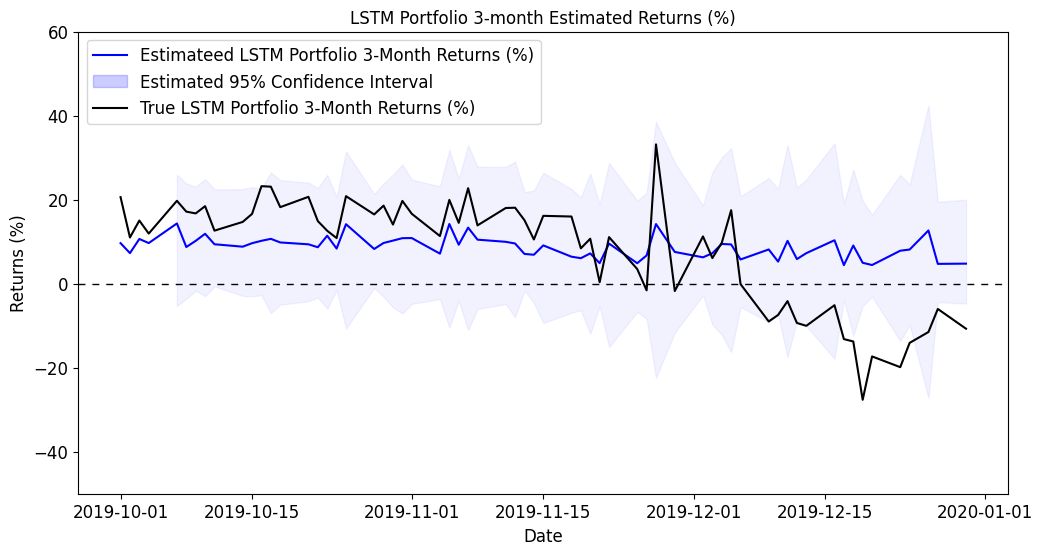

In [331]:
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the LSTM Portfolio returns
# moving average
lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] = lstm_portfolio_returns['Estimated Return (%)'].rolling(window=5).mean()
# moving standard deviation
lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'] = lstm_portfolio_returns['Estimated Return (%)'].rolling(window=5).std()
plt.figure(figsize=(12,6), facecolor='white', dpi=100)
sns.lineplot(data=lstm_portfolio_returns, x=lstm_portfolio_returns.index, y='Estimated Return (%)', color = 'blue')
# include moving average line
#sns.lineplot(data=lstm_portfolio_returns, x=lstm_portfolio_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=lstm_portfolio_returns, x=lstm_portfolio_returns.index, y='Actual Returns (%)', color='black')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5)) 

# include shaded area for the moving average confidence interval
# use the estimated risk as the standard deviation for the confidence interval
plt.fill_between(lstm_portfolio_returns.index, lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_portfolio_returns['Estimated Risk'], lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_portfolio_returns['Estimated Risk'], color = 'blue',alpha=0.05)
#plt.fill_between(lstm_portfolio_returns.index, lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_portfolio_returns['LSTM Portfolio 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('LSTM Portfolio 3-month Estimated Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylim([-50,60])
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Estimateed LSTM Portfolio 3-Month Returns (%)', 'Estimated 95% Confidence Interval', 'True LSTM Portfolio 3-Month Returns (%)'], loc='upper left', fontsize='large')

In [332]:
# load lstm_sentiment_results_optimal.csv
lstm_sentiment_portfolio_returns = pd.read_csv('lstm_sentiment_results_optimal.csv', index_col=0)
lstm_sentiment_portfolio_returns

,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'AMP', 'HON', 'ELV', 'WST', 'ACN', 'E...","[0.31303401, 0.15798765, 0.15019415, 0.0815569...",12.347634,6.650090,15.687764
2019-10-02,"['ALLE', 'AMP', 'FAST', 'DLR', 'UNH', 'TFC', '...","[0.33090323, 0.25905049, 0.14223994, 0.1125408...",14.656388,8.617718,20.262448
2019-10-03,"['ALLE', 'WRB', 'MAS', 'IRM', 'WELL', 'LYB', '...","[0.52173096, 0.1643776, 0.07493548, 0.05564816...",14.608118,6.065456,12.518400
2019-10-04,"['ALLE', 'AFL', 'DRI', 'PPL', 'MCD', 'DVA', 'P...","[0.41491002, 0.13931737, 0.1355803, 0.11078452...",13.080591,5.632369,11.941840
2019-10-07,"['ALLE', 'REGN', 'AMD', 'VTR', 'AFL', 'STX', '...","[0.51289064, 0.14837939, 0.0797153, 0.0729335,...",18.535988,8.274812,19.743274
...,...,...,...,...,...
2019-12-23,"['FISV', 'DRI', 'ENPH', 'DXCM', 'EQR', 'PH', '...","[0.31411554, 0.17869353, 0.15631962, 0.1450151...",7.238884,10.184940,-7.960323
2019-12-24,"['GNRC', 'CPRT', 'ALL', 'WTW', 'ZTS', 'KO', 'I...","[0.30600009, 0.22551406, 0.1077036, 0.10388522...",6.294604,8.446211,-14.084782
2019-12-26,"['ENPH', 'GNRC', 'KEYS', 'AAP', 'CVX', 'IP', '...","[0.30891992, 0.27882486, 0.19770641, 0.0897762...",12.656641,18.111509,-11.501805


In [333]:
# Find the average estimated returns, estimated risk, and actual returns and print them
print('Average Estimated Returns: ', lstm_sentiment_portfolio_returns['Estimated Return (%)'].mean())
print('Average Estimated Risk: ', lstm_sentiment_portfolio_returns['Estimated Risk'].mean())
print('Average Actual Returns: ', lstm_sentiment_portfolio_returns['Actual Returns (%)'].mean())
# Find the number of days with actual positive returns and print it
print('Number of Days with Actual Positive Returns: ', lstm_sentiment_portfolio_returns[lstm_sentiment_portfolio_returns['Actual Returns (%)'] > 0]['Actual Returns (%)'].count())
# Find the number of days with actual negative returns and print it
print('Number of Days with Actual Negative Returns: ', lstm_sentiment_portfolio_returns[lstm_sentiment_portfolio_returns['Actual Returns (%)'] < 0]['Actual Returns (%)'].count())

# Find the std of the actual returns and print it
print('Standard Deviation of Actual Returns: ', lstm_sentiment_portfolio_returns['Actual Returns (%)'].std())
# Find the std of the estimated returns and print it
print('Standard Deviation of Estimated Returns: ', lstm_sentiment_portfolio_returns['Estimated Return (%)'].std())
# find day with the highest actual return and print it 
print('Day with Highest Actual Return: ', lstm_sentiment_portfolio_returns[lstm_sentiment_portfolio_returns['Actual Returns (%)'] == lstm_sentiment_portfolio_returns['Actual Returns (%)'].max()].index[0])
# print the max return
print('Highest Actual Return: ', lstm_sentiment_portfolio_returns['Actual Returns (%)'].max())
# find day with the lowest actual return and print it
print('Day with Lowest Actual Return: ', lstm_sentiment_portfolio_returns[lstm_sentiment_portfolio_returns['Actual Returns (%)'] == lstm_sentiment_portfolio_returns['Actual Returns (%)'].min()].index[0])
# print the min return
print('Lowest Actual Return: ', lstm_sentiment_portfolio_returns['Actual Returns (%)'].min())
# print median return
print('Median Actual Return: ', lstm_sentiment_portfolio_returns['Actual Returns (%)'].median())


Average Estimated Returns:  8.622123764292386
Average Estimated Risk:  8.217298984650485
Average Actual Returns:  9.396732040446645
Number of Days with Actual Positive Returns:  46
Number of Days with Actual Negative Returns:  17
Standard Deviation of Actual Returns:  15.398692583556105
Standard Deviation of Estimated Returns:  3.930683687770532
Day with Highest Actual Return:  2019-11-13
Highest Actual Return:  57.14162354125372
Day with Lowest Actual Return:  2019-12-19
Lowest Actual Return:  -27.639486550096997
Median Actual Return:  11.405890653231992


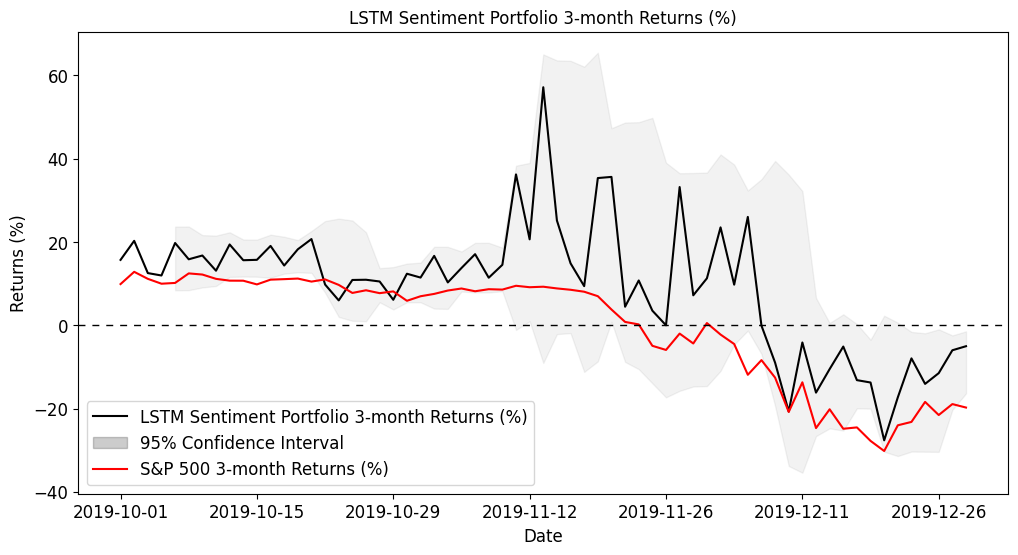

In [334]:
# plot the LSTM Sentiment Portfolio returns
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the LSTM Portfolio returns
# moving average
lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] = lstm_sentiment_portfolio_returns['Actual Returns (%)'].rolling(window=5).mean()
# moving standard deviation
lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'] = lstm_sentiment_portfolio_returns['Actual Returns (%)'].rolling(window=5).std()
plt.figure(figsize=(12,6), facecolor='white', dpi=100)
sns.lineplot(data=lstm_sentiment_portfolio_returns, x=lstm_sentiment_portfolio_returns.index, y='Actual Returns (%)', color = 'black')
# include moving average line
#sns.lineplot(data=lstm_sentiment_portfolio_returns, x=lstm_sentiment_portfolio_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=combined_returns, x=lstm_sentiment_portfolio_returns.index, y='S&P 500 - 3 Month Return (%)', color='red')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5))

# only have 6 dates on the x-axis displayed
plt.xticks(np.arange(0, len(lstm_sentiment_portfolio_returns.index), 10), lstm_sentiment_portfolio_returns.index[np.arange(0, len(lstm_sentiment_portfolio_returns.index), 10)])


# include shaded area for the moving average confidence interval
plt.fill_between(lstm_sentiment_portfolio_returns.index, lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'], lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('LSTM Sentiment Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(['LSTM Sentiment Portfolio 3-month Returns (%)', '95% Confidence Interval', 'S&P 500 3-month Returns (%)'], loc='lower left', fontsize='large')

plt.show()

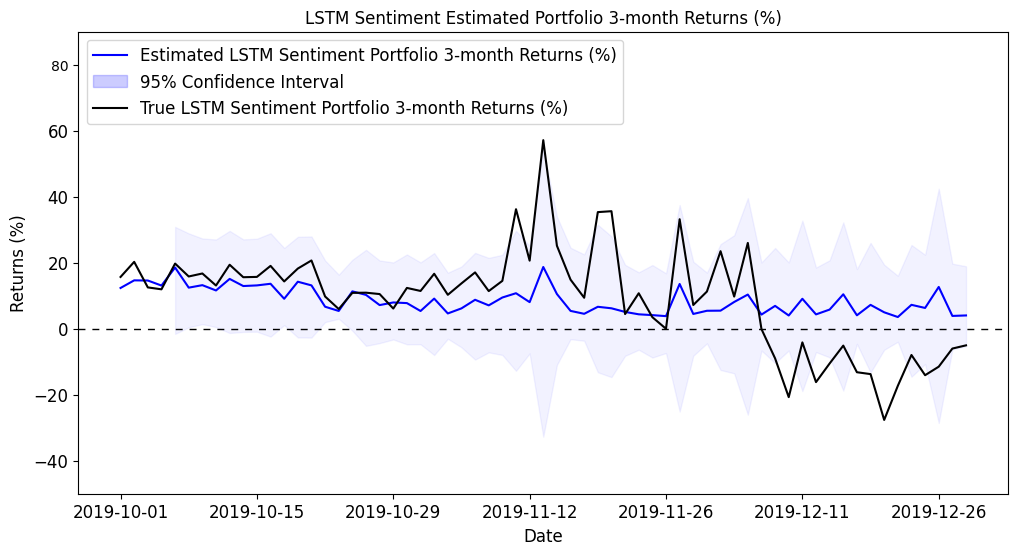

In [337]:
# plot the LSTM Sentiment Portfolio returns
import seaborn as sns
import matplotlib.pyplot as plt
# make the plot for the LSTM Portfolio returns
# moving average
lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] = lstm_sentiment_portfolio_returns['Estimated Return (%)'].rolling(window=5).mean()
# moving standard deviation
lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'] = lstm_sentiment_portfolio_returns['Estimated Return (%)'].rolling(window=5).std()
plt.figure(figsize=(12,6), facecolor='white', dpi=100)
sns.lineplot(data=lstm_sentiment_portfolio_returns, x=lstm_sentiment_portfolio_returns.index, y='Estimated Return (%)', color = 'blue')
# include moving average line
#sns.lineplot(data=lstm_sentiment_portfolio_returns, x=lstm_sentiment_portfolio_returns.index, y='Random Monkey - 3 Month Returns (%) - Moving Average', color='red')
# include the 0 horizontal line make space in between dashed
# make a line for the S&P 500 returns
sns.lineplot(data=lstm_sentiment_portfolio_returns, x=lstm_sentiment_portfolio_returns.index, y='Actual Returns (%)', color='black')
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1, dashes=(5, 5))

# only have 6 dates on the x-axis displayed
plt.xticks(np.arange(0, len(lstm_sentiment_portfolio_returns.index), 10), lstm_sentiment_portfolio_returns.index[np.arange(0, len(lstm_sentiment_portfolio_returns.index), 10)])


# include shaded area for the moving average confidence interval
# use the estimated risk as the standard deviation for the confidence interval
plt.fill_between(lstm_sentiment_portfolio_returns.index, lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_sentiment_portfolio_returns['Estimated Risk'], lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_sentiment_portfolio_returns['Estimated Risk'], color = 'blue',alpha=0.05)
#plt.fill_between(lstm_sentiment_portfolio_returns.index, lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] - 1.96 * lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'], lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Average'] + 1.96 * lstm_sentiment_portfolio_returns['LSTM Sentiment Portfolio 3 Month Returns (%) - Moving Standard Deviation'], color = 'black',alpha=0.05)
plt.title('LSTM Sentiment Estimated Portfolio 3-month Returns (%)')
plt.ylabel('Returns (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
# make x and y ticks larger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(['Estimated LSTM Sentiment Portfolio 3-month Returns (%)', '95% Confidence Interval', 'True LSTM Sentiment Portfolio 3-month Returns (%)'], loc='upper left', fontsize='large')
plt.ylim(-50, 90)
plt.show()

In [385]:
lstm_sentiment_portfolio_returns['Actual Returns (%)']

Date
2019-10-01    15.687764
2019-10-02    20.262448
2019-10-03    12.518400
2019-10-04    11.941840
2019-10-07    19.743274
                ...    
2019-12-23    -7.960323
2019-12-24   -14.084782
2019-12-26   -11.501805
2019-12-27    -6.010027
2019-12-30    -5.037197
Name: Actual Returns (%), Length: 63, dtype: float64

In [398]:
lstm_sentiment_portfolio_returns['Actual Returns (%)'].values

array([ 1.56877639e+01,  2.02624480e+01,  1.25184001e+01,  1.19418398e+01,
        1.97432741e+01,  1.58309894e+01,  1.67393995e+01,  1.30930205e+01,
        1.93888887e+01,  1.56071218e+01,  1.57038331e+01,  1.90446363e+01,
        1.43311690e+01,  1.82312673e+01,  2.06877686e+01,  9.76884006e+00,
        5.96190013e+00,  1.08663870e+01,  1.09210850e+01,  1.05026388e+01,
        6.10978708e+00,  1.23651334e+01,  1.14422732e+01,  1.66521647e+01,
        1.02783215e+01,  1.37346398e+01,  1.70652117e+01,  1.14058907e+01,
        1.45088500e+01,  3.62161099e+01,  2.06249573e+01,  5.71416235e+01,
        2.51469821e+01,  1.48669746e+01,  9.38266608e+00,  3.53356456e+01,
        3.56123125e+01,  4.44152226e+00,  1.07467344e+01,  3.49713859e+00,
       -1.33466489e-02,  3.31775095e+01,  7.18568098e+00,  1.12628463e+01,
        2.34946695e+01,  9.73814373e+00,  2.60008567e+01, -9.77428315e-02,
       -8.98844932e+00, -2.07287896e+01, -4.14167591e+00, -1.61810812e+01,
       -1.05266140e+01, -

In [383]:
# add the LSTM and LSTM Sentiment Portfolio returns to the combined returns dataframe
combined_returns['LSTM Portfolio - 3 Month Returns (%)'] = lstm_portfolio_returns['Actual Returns (%)']


In [402]:
combined_returns['LSTM Portfolio Sentiment - 3 Month Returns (%)'] = lstm_sentiment_portfolio_returns['Actual Returns (%)'].values

In [403]:
combined_returns

,SVM Portfolio 3 Month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey - 3 Month Returns (%),LSTM Portfolio - 3 Month Returns (%),LSTM Portfolio Sentiment - 3 Month Returns (%)
2019-10-01,11.6,9.881134,4.6,20.622943,15.687764
2019-10-02,14.9,12.821675,19.1,11.012420,20.262448
2019-10-03,16.0,11.139177,14.4,15.039801,12.518400
2019-10-04,14.9,9.968463,9.0,11.941840,11.941840
2019-10-07,14.9,10.153495,9.8,19.743274,19.743274
...,...,...,...,...,...
2019-12-23,-33.0,-23.214877,-33.4,-19.867359,-7.960323
2019-12-24,-29.1,-18.406450,-23.7,-14.084782,-14.084782
2019-12-26,-26.8,-21.557388,-26.8,-11.501805,-11.501805
2019-12-27,-27.5,-18.931059,-18.4,-6.010027,-6.010027


In [468]:
# mean, standard deviation, median for each of these the svm, sp500, random monkey, lstm, lstm sentiment
# mean
combined_returns.mean()

# standard deviation
combined_returns.std()

# median
combined_returns.median()

print('Mean'    ,combined_returns.mean())
print('Standard Deviation', combined_returns.std())
print('Median'    , combined_returns.median())



Mean SVM Portfolio 3 Month Returns (%)                 0.198413
S&P 500 - 3 Month Return (%)                     -0.379688
Random Monkey - 3 Month Returns (%)              -2.511111
LSTM Portfolio - 3 Month Returns (%)              8.103379
LSTM Portfolio Sentiment - 3 Month Returns (%)    9.396732
dtype: float64
Standard Deviation SVM Portfolio 3 Month Returns (%)                 13.976864
S&P 500 - 3 Month Return (%)                      13.323599
Random Monkey - 3 Month Returns (%)               14.935378
LSTM Portfolio - 3 Month Returns (%)              13.080442
LSTM Portfolio Sentiment - 3 Month Returns (%)    15.398693
dtype: float64
Median SVM Portfolio 3 Month Returns (%)                  6.200000
S&P 500 - 3 Month Return (%)                       7.698179
Random Monkey - 3 Month Returns (%)                4.300000
LSTM Portfolio - 3 Month Returns (%)              12.606142
LSTM Portfolio Sentiment - 3 Month Returns (%)    11.405891
dtype: float64


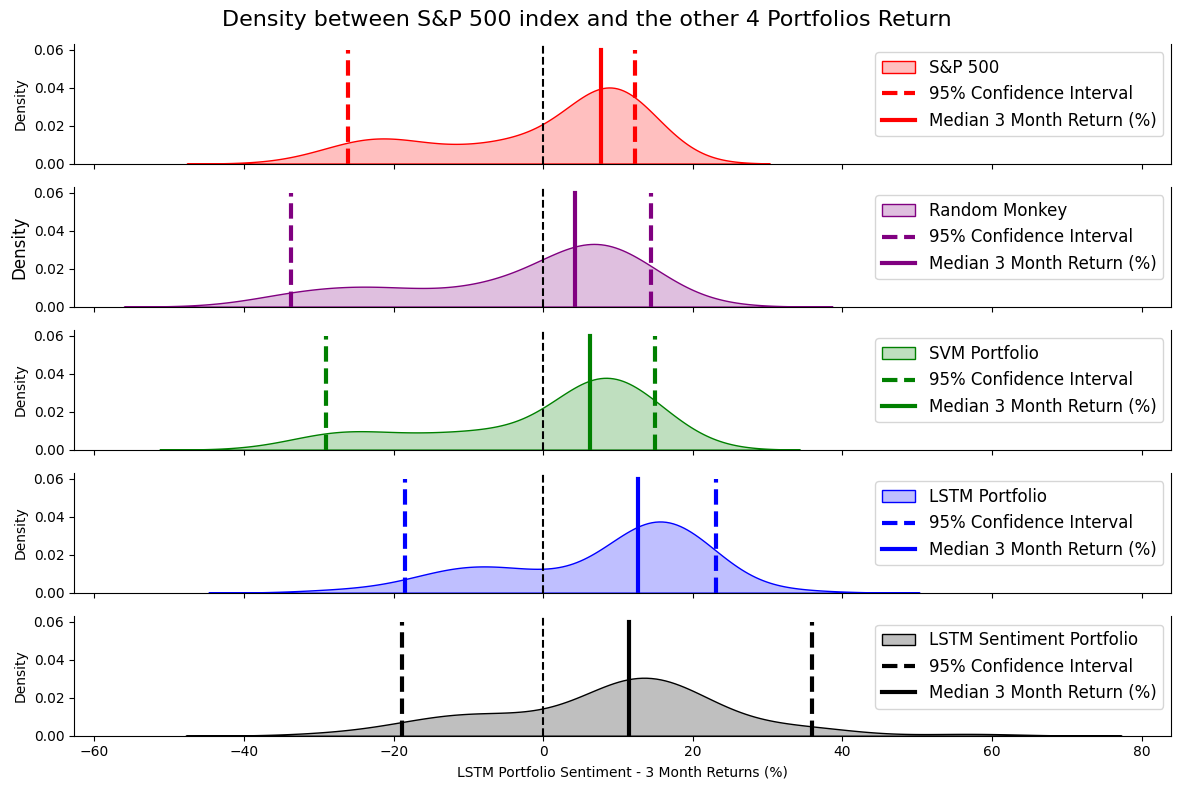

In [466]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True, sharey=True, dpi=100)

# Define labels and columns
labels = ['S&P 500', 'Random Monkey', 'SVM Portfolio', 'LSTM Portfolio', 'LSTM Sentiment Portfolio']
columns = ['S&P 500 - 3 Month Return (%)', 'Random Monkey - 3 Month Returns (%)', 'SVM Portfolio 3 Month Returns (%)', 'LSTM Portfolio - 3 Month Returns (%)', 'LSTM Portfolio Sentiment - 3 Month Returns (%)' ]
colors = ['red', 'purple', 'green', 'blue', 'black']

# Iterate over labels, columns and axes simultaneously
for label, column, color, ax in zip(labels, columns, colors, axes):
    # Make density plot
    sns.kdeplot(data=combined_returns, x=column, fill=True, ax=ax, label=label, color=color)

    # Draw vertical lines for the confidence intervals
    # confidence interval quantiles
    ci_lower = np.quantile(combined_returns[column], 0.025)
    ci_upper = np.quantile(combined_returns[column], 0.975)
    ax.plot([ci_lower, ci_lower], [0, 0.06], color=color, linestyle='--', linewidth=3)
    # include median line
    median = np.quantile(combined_returns[column], 0.5)
    ax.plot([median, median], [0, 0.06], color=color, linestyle='-', linewidth=3)
    ax.plot([ci_upper, ci_upper], [0, 0.06], color=color, linestyle='--', linewidth=3)
    
    
    # Add zero line
    ax.axvline(x=0, color='black', linestyle='--')
    # remove box around plot
    ax.spines['top'].set_visible(False)
    # Set title and legend
    #ax.set_title(label)
    # including median in legend
    ax.legend([label, '95% Confidence Interval', 'Median 3 Month Return (%)'], fontsize='large')

# make title for entire plot
fig.suptitle('Density between S&P 500 index and the other 4 Portfolios Return', fontsize=16)
# Set common labels
axes[1].set_ylabel('Density', fontsize=12)
axes[2].set_xlabel('Returns (%)', fontsize=12)

plt.tight_layout()
plt.show()

In [115]:
# average return of each column
average_return = combined_returns.mean()
average_return

SVM Portfolio 3 Month Returns (%)     -0.165625
S&P 500 - 3 Month Return (%)          -0.741450
Random Monkey - 3 Month Returns (%)   -2.981250
dtype: float64

In [116]:
# standard deviation of each column
standard_deviation = combined_returns.std()
standard_deviation

SVM Portfolio 3 Month Returns (%)      14.168042
S&P 500 - 3 Month Return (%)           13.530569
Random Monkey - 3 Month Returns (%)    15.286293
dtype: float64

In [158]:
# 95% confidence interval of each column
confidence_interval = combined_returns.quantile([0.025, 0.975])
confidence_interval

,SVM Portfolio 3-month Returns (%),S&P 500 - 3 Month Return (%),Random Monkey 63-day Returns (%)
0.025,-30.6425,-26.096485,-33.6550
0.975,14.8425,12.286300,14.3425


In [159]:
# calculate median of each column
median = combined_returns.median()
median

SVM Portfolio 3-month Returns (%)    6.150000
S&P 500 - 3 Month Return (%)         7.609881
Random Monkey 63-day Returns (%)     3.750000
dtype: float64

__Non_Parametric Statistical Tests__

In [349]:
import numpy as np
from scipy.stats import friedmanchisquare

# let's assume these are your 3-month returns for each model
svm_returns = combined_returns['SVM Portfolio 3 Month Returns (%)']
random_monkey_returns = combined_returns['Random Monkey - 3 Month Returns (%)']
lstm_returns = lstm_portfolio_returns['Actual Returns (%)']
lstm_sentiment_returns = lstm_sentiment_portfolio_returns['Actual Returns (%)']
# apply Friedman test
stat, p = friedmanchisquare(svm_returns, random_monkey_returns, lstm_returns, lstm_sentiment_returns)

print('Statistics=%.3f, p=%.23f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=94.671, p=0.00000000000000000002173
Different distributions (reject H0)


In [348]:
import numpy as np
from scipy.stats import friedmanchisquare

# let's assume these are your 3-month returns for each model
svm_returns = combined_returns['SVM Portfolio 3 Month Returns (%)']
sp500_returns = combined_returns['S&P 500 - 3 Month Return (%)']
random_monkey_returns = combined_returns['Random Monkey - 3 Month Returns (%)']
lstm_returns = lstm_portfolio_returns['Actual Returns (%)']
lstm_sentiment_returns = lstm_sentiment_portfolio_returns['Actual Returns (%)']
# apply Friedman test
stat, p = friedmanchisquare(svm_returns, sp500_returns, random_monkey_returns, lstm_returns, lstm_sentiment_returns)

print('Statistics=%.3f, p=%.30f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=133.888, p=0.000000000000000000000000000574
Different distributions (reject H0)


In [357]:
from scipy.stats import wilcoxon

# Pairwise comparison for SVM vs S&P 500
stat, p = wilcoxon(svm_returns, sp500_returns)
print('Statistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('SVM vs SP500: Same distribution (fail to reject H0)')
else:
    print('SVM vs SP500: Different distribution (reject H0)')

# Pairwise comparison for SVM vs Random Monkey
stat, p = wilcoxon(svm_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('SVM vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SVM vs Random Monkey: Different distribution (reject H0)')

# Pairwise comparison for S&P 500 vs Random Monkey
stat, p = wilcoxon(sp500_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('SP500 vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('SP500 vs Random Monkey: Different distribution (reject H0)')

# Pairwise comparison for SVM vs LSTM
stat, p = wilcoxon(svm_returns, lstm_returns)
print('\nStatistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('SVM vs LSTM: Same distribution (fail to reject H0)')
else:
    print('SVM vs LSTM: Different distribution (reject H0)')

# Pairwise comparison for SVM vs LSTM Sentiment
stat, p = wilcoxon(svm_returns, lstm_sentiment_returns)
print('\nStatistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('SVM vs LSTM Sentiment: Same distribution (fail to reject H0)')
else:
    print('SVM vs LSTM Sentiment: Different distribution (reject H0)')

# Pairwise comparison for LSTM vs LSTM Sentiment
stat, p = wilcoxon(lstm_returns, lstm_sentiment_returns)
print('\nStatistics=%.3f, p=%.10f' % (stat, p))
if p > alpha:
    print('LSTM vs LSTM Sentiment: Same distribution (fail to reject H0)')
else:
    print('LSTM vs LSTM Sentiment: Different distribution (reject H0)')

# Pairwise comparison for LSTM vs S&P 500
stat, p = wilcoxon(lstm_returns, sp500_returns)
print('\nStatistics=%.3f, p=%.15f' % (stat, p))
if p > alpha:
    print('LSTM vs S&P 500: Same distribution (fail to reject H0)')
else:
    print('LSTM vs S&P 500: Different distribution (reject H0)')
    
# Pairwise comparison for LSTM Sentiment vs S&P 500
stat, p = wilcoxon(lstm_sentiment_returns, sp500_returns)
print('\nStatistics=%.3f, p=%.15f' % (stat, p))
if p > alpha:
    print('LSTM Sentiment vs S&P 500: Same distribution (fail to reject H0)')
else:
    print('LSTM Sentiment vs S&P 500: Different distribution (reject H0)')

# Pairwise comparison for LSTM vs Random Monkey
stat, p = wilcoxon(lstm_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.20f' % (stat, p))
if p > alpha:
    print('LSTM vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('LSTM vs Random Monkey: Different distribution (reject H0)')
    
# Pairwise comparison for LSTM Sentiment vs Random Monkey
stat, p = wilcoxon(lstm_sentiment_returns, random_monkey_returns)
print('\nStatistics=%.3f, p=%.12f' % (stat, p))
if p > alpha:
    print('LSTM Sentiment vs Random Monkey: Same distribution (fail to reject H0)')
else:
    print('LSTM Sentiment vs Random Monkey: Different distribution (reject H0)')


Statistics=863.000, p=0.3208634410
SVM vs SP500: Same distribution (fail to reject H0)

Statistics=504.000, p=0.0009236256
SVM vs Random Monkey: Different distribution (reject H0)

Statistics=521.000, p=0.0008559044
SP500 vs Random Monkey: Different distribution (reject H0)

Statistics=122.000, p=0.0000000013
SVM vs LSTM: Different distribution (reject H0)

Statistics=186.000, p=0.0000000183
SVM vs LSTM Sentiment: Different distribution (reject H0)

Statistics=413.000, p=0.8206015978
LSTM vs LSTM Sentiment: Same distribution (fail to reject H0)

Statistics=5.000, p=0.000000000006573
LSTM vs S&P 500: Different distribution (reject H0)

Statistics=28.000, p=0.000000000019572
LSTM Sentiment vs S&P 500: Different distribution (reject H0)

Statistics=33.000, p=0.00000000002473139434
LSTM vs Random Monkey: Different distribution (reject H0)

Statistics=62.000, p=0.000000000094
LSTM Sentiment vs Random Monkey: Different distribution (reject H0)


In [358]:
# The sign test, which does not assume that the distributions are symmetrical
from scipy import stats

# Calculate differences for each pair of portfolios
diff_svm_sp500 = svm_returns - sp500_returns
diff_svm_random = svm_returns - random_monkey_returns
diff_svm_lstm = svm_returns - lstm_returns
diff_svm_lstm_sentiment = svm_returns - lstm_sentiment_returns
diff_sp500_random = sp500_returns - random_monkey_returns
diff_sp500_random = sp500_returns - random_monkey_returns
diff_lstm_sp500 = lstm_returns - sp500_returns
diff_lstm_random = lstm_returns - random_monkey_returns
diff_lstm_sentiment_sp500 = lstm_sentiment_returns - sp500_returns
diff_lstm_sentiment_random = lstm_sentiment_returns - random_monkey_returns
diff_lstm_lstm_sentiment = lstm_returns - lstm_sentiment_returns


# Perform Sign test
p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
p_value_svm_lstm = stats.binom_test((diff_svm_lstm > 0).sum(), n=len(diff_svm_lstm), alternative='two-sided')
p_value_svm_lstm_sentiment = stats.binom_test((diff_svm_lstm_sentiment > 0).sum(), n=len(diff_svm_lstm_sentiment), alternative='two-sided')
p_value_sp500_random = stats.binom_test((diff_sp500_random > 0).sum(), n=len(diff_sp500_random), alternative='two-sided')
p_value_lstm_sp500 = stats.binom_test((diff_lstm_sp500 > 0).sum(), n=len(diff_lstm_sp500), alternative='two-sided')
p_value_lstm_random = stats.binom_test((diff_lstm_random > 0).sum(), n=len(diff_lstm_random), alternative='two-sided')
p_value_lstm_sentiment_sp500 = stats.binom_test((diff_lstm_sentiment_sp500 > 0).sum(), n=len(diff_lstm_sentiment_sp500), alternative='two-sided')
p_value_lstm_sentiment_random = stats.binom_test((diff_lstm_sentiment_random > 0).sum(), n=len(diff_lstm_sentiment_random), alternative='two-sided')
p_value_lstm_lstm_sentiment = stats.binom_test((diff_lstm_lstm_sentiment > 0).sum(), n=len(diff_lstm_lstm_sentiment), alternative='two-sided')

print(f"p-value for the difference between SVM portfolio and SP500: {p_value_svm_sp500}")
print(f"p-value for the difference between SVM portfolio and Random portfolio: {p_value_svm_random}")
print(f"p-value for the difference between SVM portfolio and LSTM portfolio: {p_value_svm_lstm}")
print(f"p-value for the difference between SVM portfolio and LSTM Sentiment portfolio: {p_value_svm_lstm_sentiment}")
print(f"p-value for the difference between SP500 and Random portfolio: {p_value_sp500_random}")
print(f"p-value for the difference between LSTM portfolio and SP500: {p_value_lstm_sp500}")
print(f"p-value for the difference between LSTM portfolio and Random portfolio: {p_value_lstm_random}")
print(f"p-value for the difference between LSTM Sentiment portfolio and SP500: {p_value_lstm_sentiment_sp500}")
print(f"p-value for the difference between LSTM Sentiment portfolio and Random portfolio: {p_value_lstm_sentiment_random}")
print(f"p-value for the difference between LSTM portfolio and LSTM Sentiment portfolio: {p_value_lstm_lstm_sentiment}")

p-value for the difference between SVM portfolio and SP500: 0.44996253629022254
p-value for the difference between SVM portfolio and Random portfolio: 0.022574972673257185
p-value for the difference between SVM portfolio and LSTM portfolio: 9.761673086614714e-10
p-value for the difference between SVM portfolio and LSTM Sentiment portfolio: 2.350988701644575e-38
p-value for the difference between SP500 and Random portfolio: 0.0022275315109880345
p-value for the difference between LSTM portfolio and SP500: 4.373671563806525e-16
p-value for the difference between LSTM portfolio and Random portfolio: 1.3821257506541063e-13
p-value for the difference between LSTM Sentiment portfolio and SP500: 2.350988701644575e-38
p-value for the difference between LSTM Sentiment portfolio and Random portfolio: 2.350988701644575e-38
p-value for the difference between LSTM portfolio and LSTM Sentiment portfolio: 2.350988701644575e-38


C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1585185071.py:19: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_sp500 = stats.binom_test((diff_svm_sp500 > 0).sum(), n=len(diff_svm_sp500), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1585185071.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_random = stats.binom_test((diff_svm_random > 0).sum(), n=len(diff_svm_random), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1585185071.py:21: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value_svm_lstm = stats.binom_test((diff_svm_lstm > 0).sum(), n=len(diff_svm_lstm), alternative='two-sided')
C:\Users\nicol\AppData\Local\Temp\ipykernel_19192\1585185071.py:22:

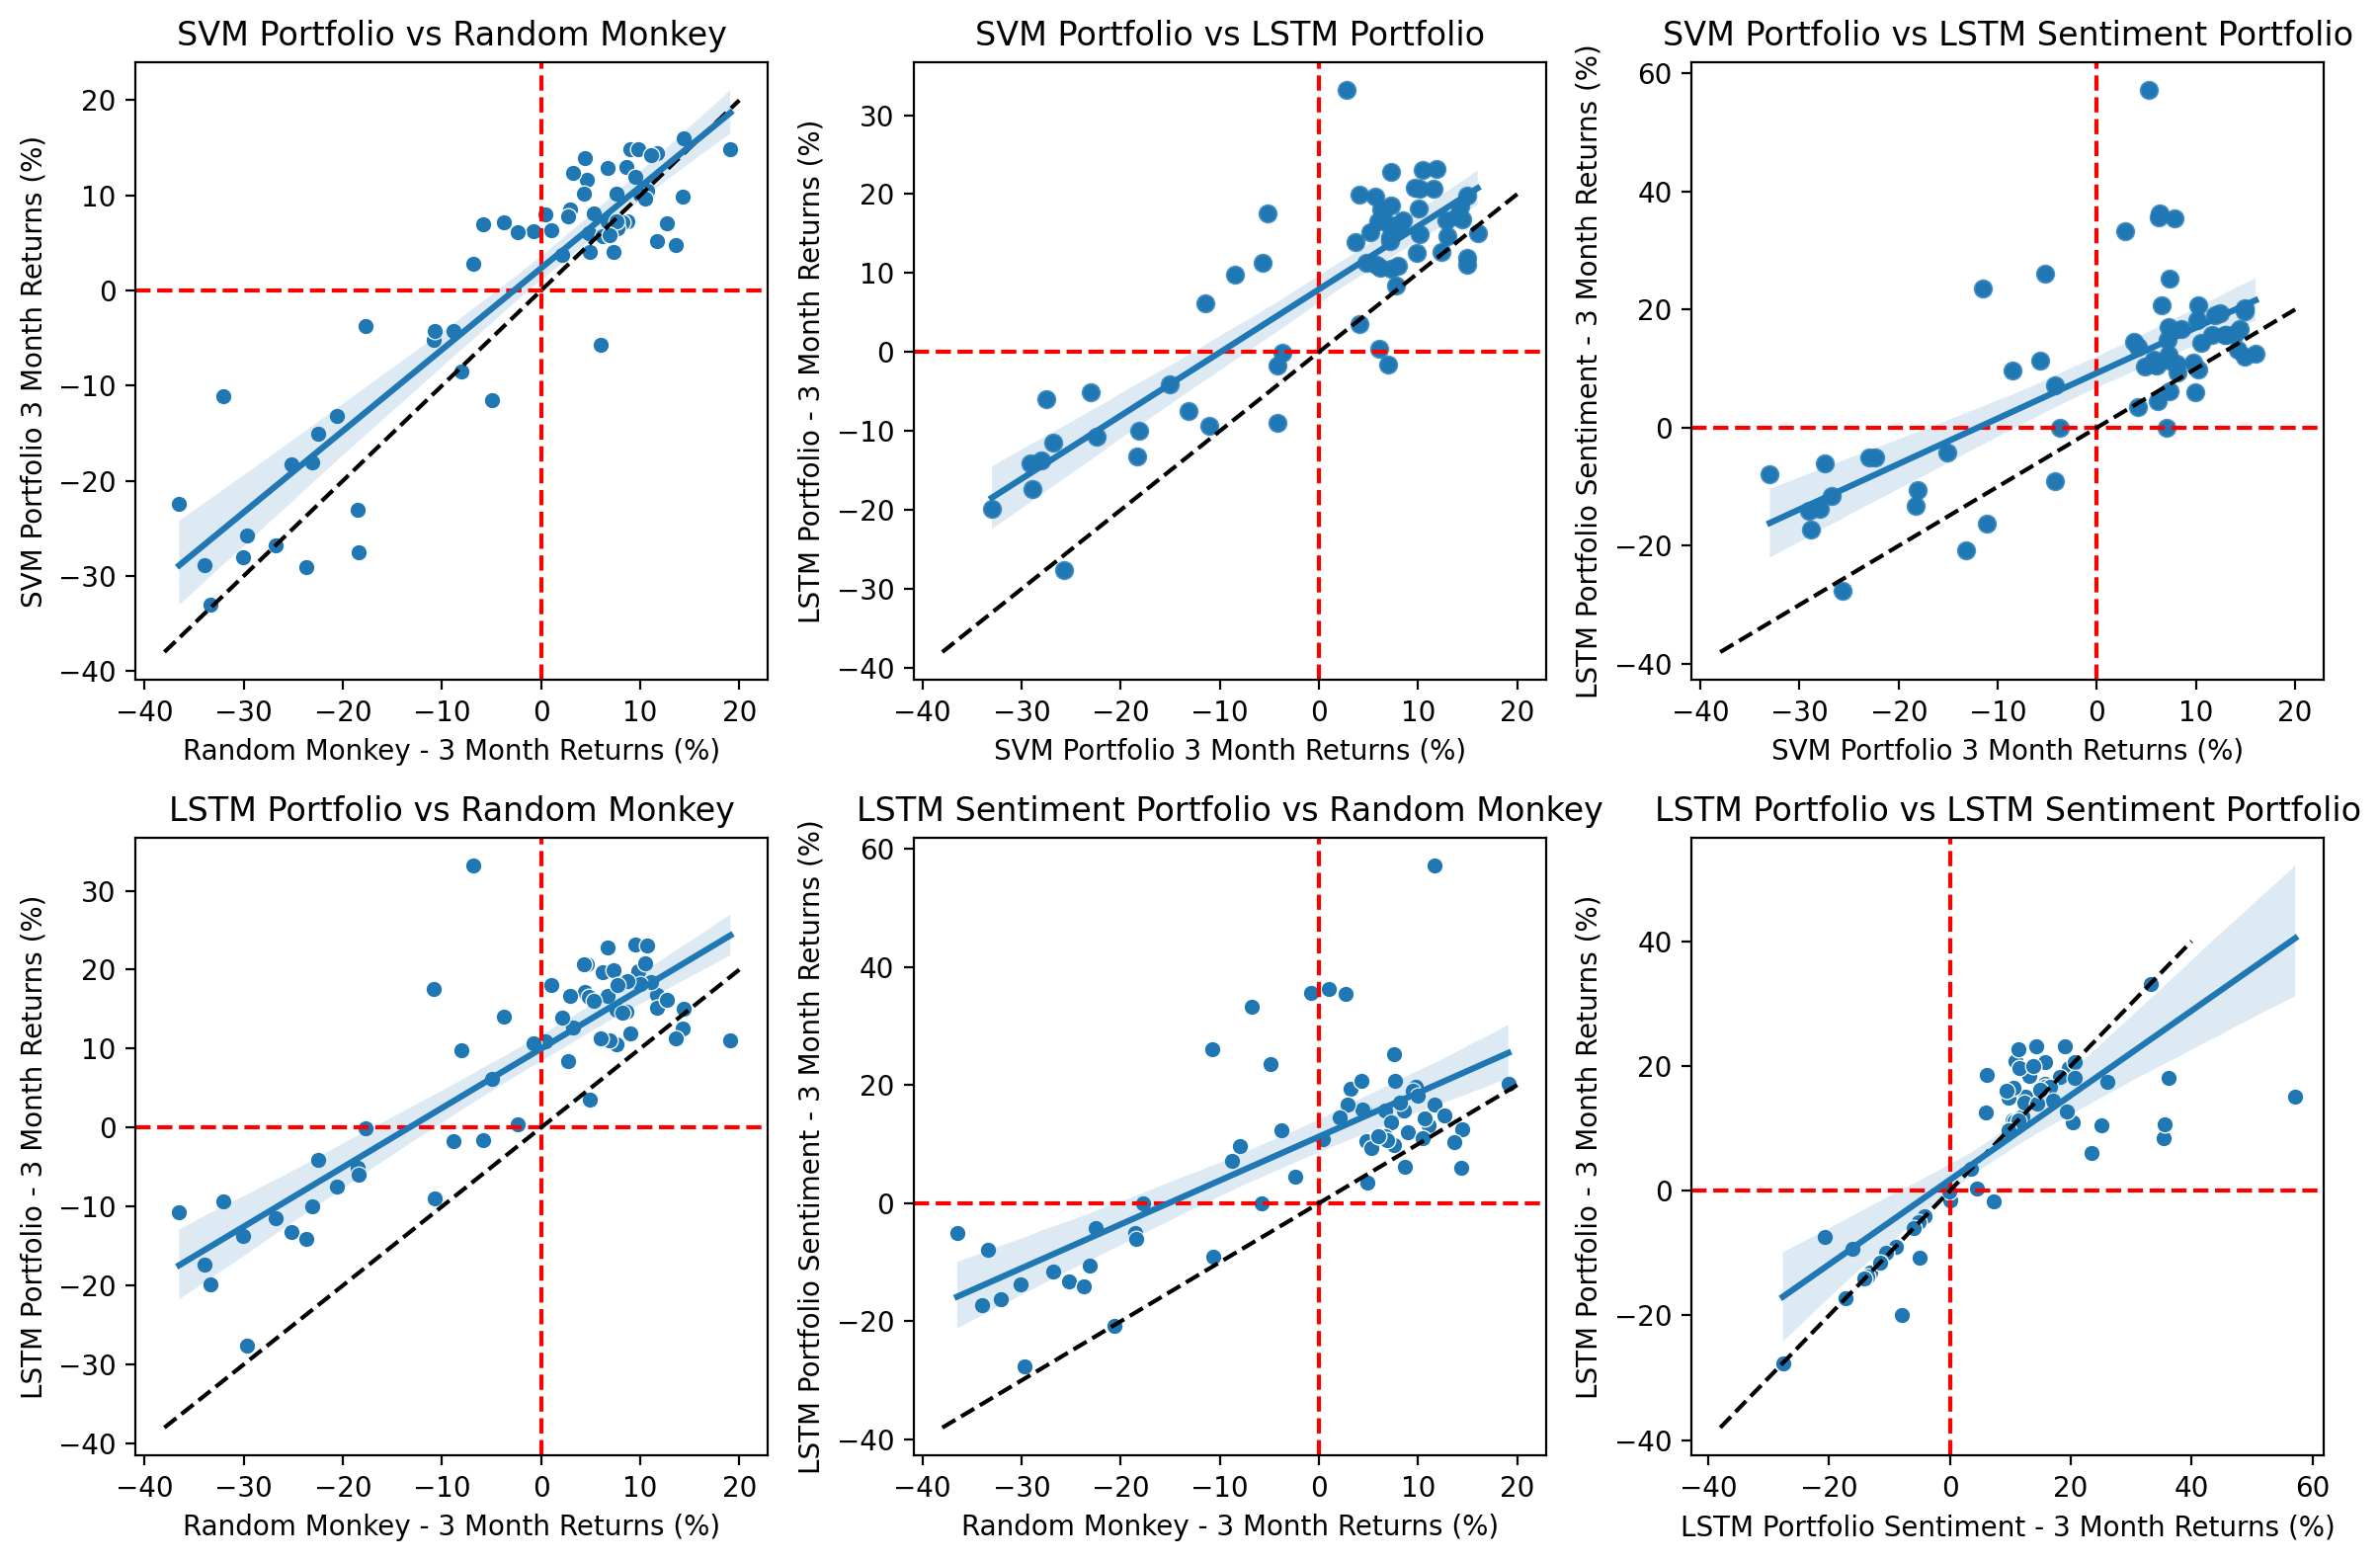

In [457]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(12, 8),dpi=200)

# SVM Portfolio vs Random Monkey
sns.scatterplot(ax=axes[0, 0], data=combined_returns, y='SVM Portfolio 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axvline(x=0, color='r', linestyle='--')
axes[0, 0].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[0, 0], data=combined_returns, y='SVM Portfolio 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)', scatter=False)
axes[0, 0].set_title('SVM Portfolio vs Random Monkey')

# SVM Portfolio vs LSTM Portfolio
sns.scatterplot(ax=axes[0, 1], data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='LSTM Portfolio - 3 Month Returns (%)')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[0, 1], data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='LSTM Portfolio - 3 Month Returns (%)')
axes[0, 1].set_title('SVM Portfolio vs LSTM Portfolio')

# SVM Portfolio vs LSTM Sentiment Portfolio
sns.scatterplot(ax=axes[0, 2], data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='LSTM Portfolio Sentiment - 3 Month Returns (%)')
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].axvline(x=0, color='r', linestyle='--')
axes[0, 2].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[0, 2], data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='LSTM Portfolio Sentiment - 3 Month Returns (%)')
axes[0, 2].set_title('SVM Portfolio vs LSTM Sentiment Portfolio')

# LSTM Portfolio vs Random Monkey
sns.scatterplot(ax=axes[1, 0], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[1, 0], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)', scatter=False)
axes[1, 0].set_title('LSTM Portfolio vs Random Monkey')

# LSTM Sentiment Portfolio vs Random Monkey
sns.scatterplot(ax=axes[1, 1], data=combined_returns, y='LSTM Portfolio Sentiment - 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[1, 1], data=combined_returns, y='LSTM Portfolio Sentiment - 3 Month Returns (%)', x='Random Monkey - 3 Month Returns (%)', scatter=False)
axes[1, 1].set_title('LSTM Sentiment Portfolio vs Random Monkey')

# LSTM Portfolio vs LSTM Sentiment Portfolio
sns.scatterplot(ax=axes[1, 2], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='LSTM Portfolio Sentiment - 3 Month Returns (%)')
axes[1, 2].axhline(y=0, color='r', linestyle='--')
axes[1, 2].axvline(x=0, color='r', linestyle='--')
axes[1, 2].plot([-38, 40], [-38, 40], color='black', linestyle='--')
sns.regplot(ax=axes[1, 2], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='LSTM Portfolio Sentiment - 3 Month Returns (%)', scatter=False)
axes[1, 2].set_title('LSTM Portfolio vs LSTM Sentiment Portfolio')

plt.tight_layout()
plt.show()


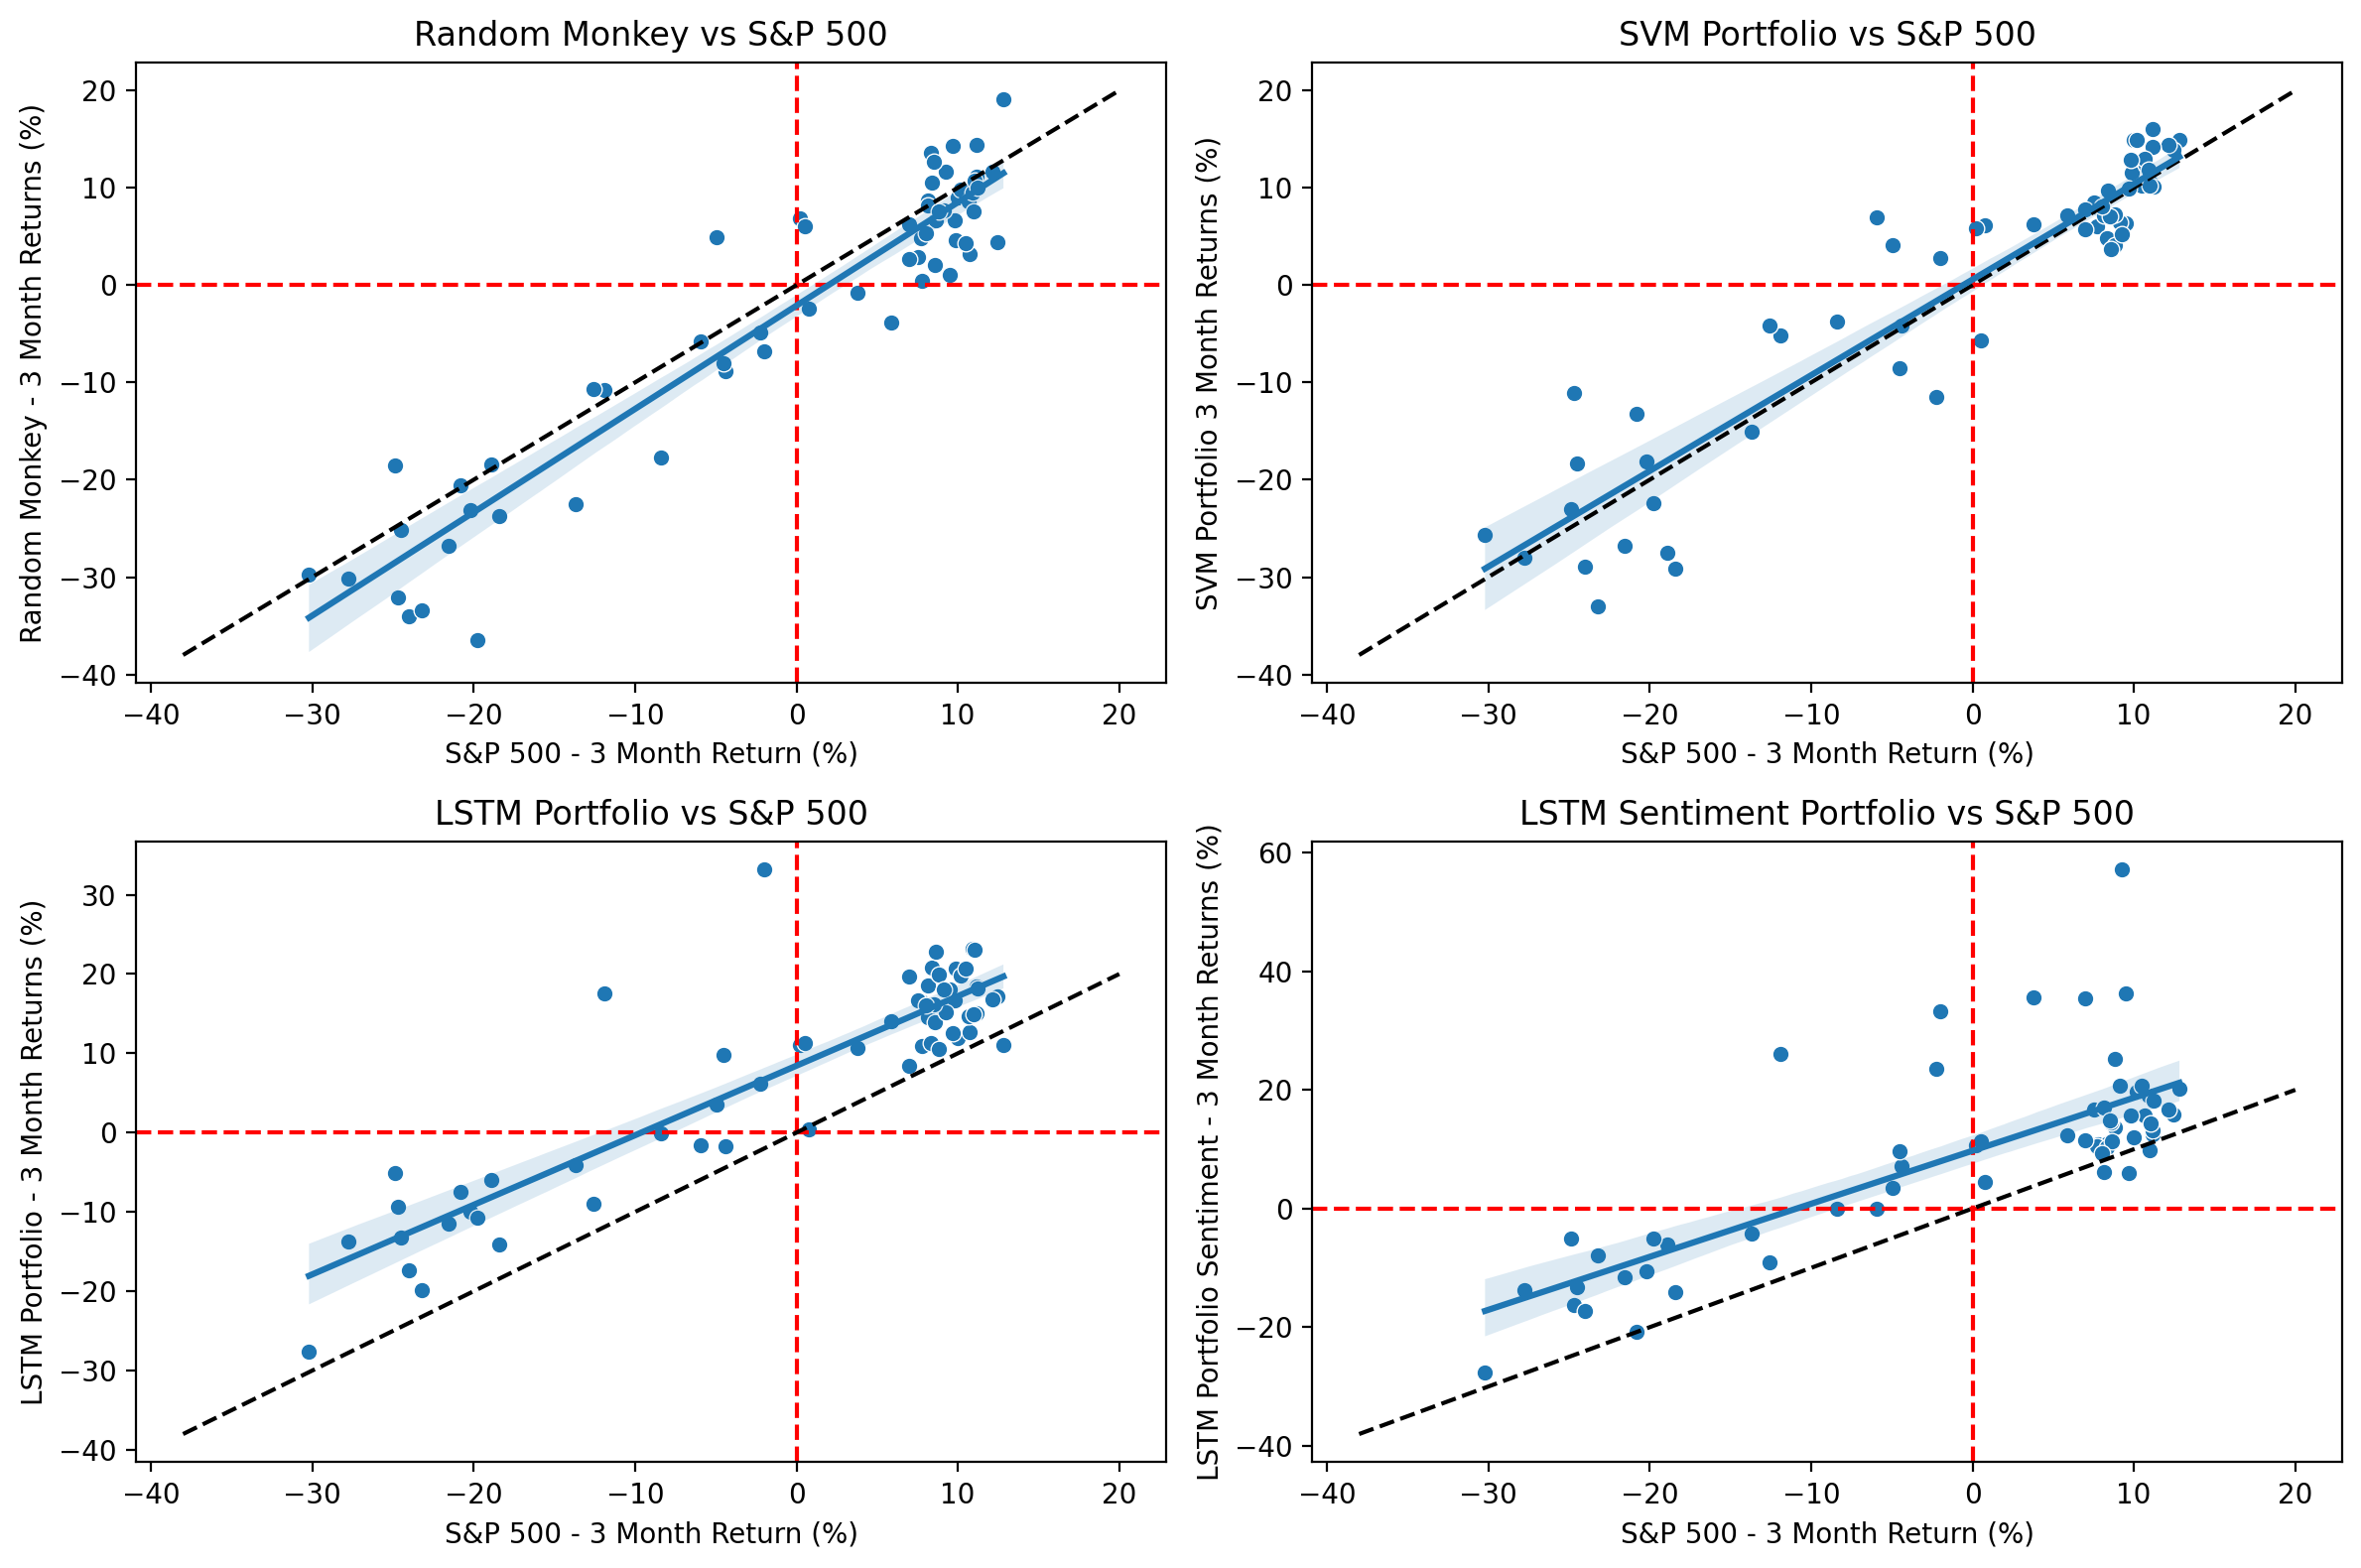

In [464]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8),dpi=200)

# Random Monkey vs S&P 500
sns.scatterplot(ax=axes[0,0], data=combined_returns, y='Random Monkey - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)')
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].axvline(x=0, color='r', linestyle='--')
axes[0,0].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[0,0], data=combined_returns, y='Random Monkey - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)', scatter=False)
axes[0,0].set_title('Random Monkey vs S&P 500')

# SVM Portfolio vs S&P 500
sns.scatterplot(ax=axes[0,1], data=combined_returns, y='SVM Portfolio 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].axvline(x=0, color='r', linestyle='--')
axes[0,1].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[0,1], data=combined_returns, y='SVM Portfolio 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)', scatter=False)
axes[0,1].set_title('SVM Portfolio vs S&P 500')

# LSTM Portfolio vs S&P 500
sns.scatterplot(ax=axes[1,0], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].axvline(x=0, color='r', linestyle='--')
axes[1,0].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[1,0], data=combined_returns, y='LSTM Portfolio - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)', scatter=False)
axes[1,0].set_title('LSTM Portfolio vs S&P 500')

# LSTM Sentiment Portfolio vs S&P 500
sns.scatterplot(ax=axes[1,1], data=combined_returns, y='LSTM Portfolio Sentiment - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].axvline(x=0, color='r', linestyle='--')
axes[1,1].plot([-38, 20], [-38, 20], color='black', linestyle='--')
sns.regplot(ax=axes[1,1], data=combined_returns, y='LSTM Portfolio Sentiment - 3 Month Returns (%)', x='S&P 500 - 3 Month Return (%)', scatter=False)
axes[1,1].set_title('LSTM Sentiment Portfolio vs S&P 500')

plt.tight_layout()
plt.show()




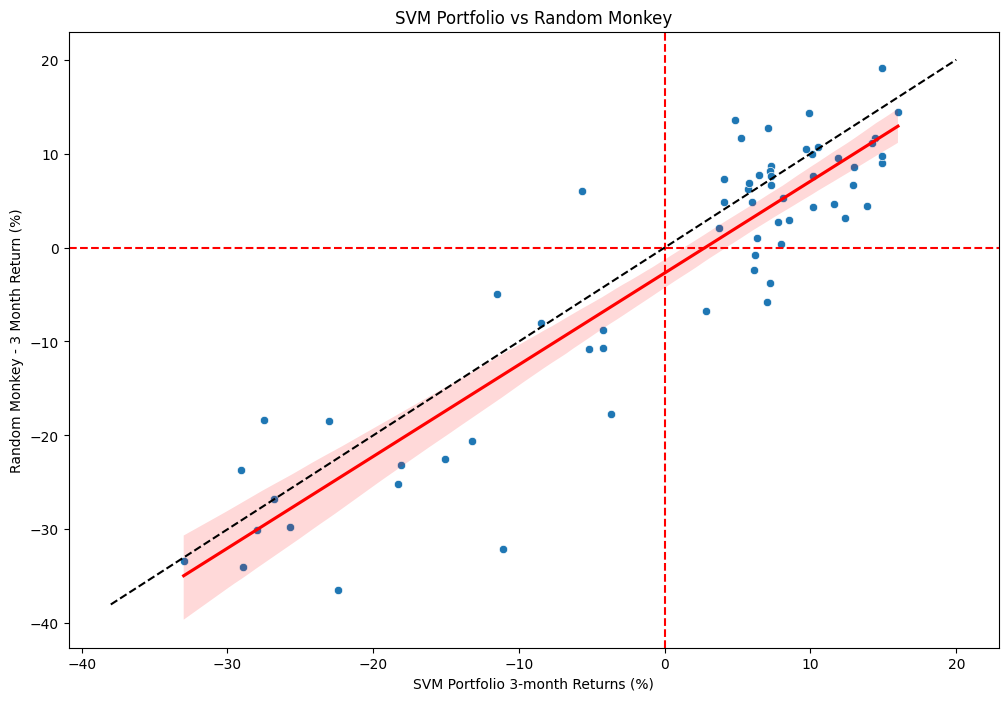

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8), facecolor='white', dpi=100)
sns.scatterplot(data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='Random Monkey - 3 Month Returns (%)')
# make 0 horizontal line
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

# Add diagonal line x=y
plt.plot([-38, 20], [-38, 20], color='black', linestyle='--')

# Add linear regression line
sns.regplot(data=combined_returns, x='SVM Portfolio 3 Month Returns (%)', y='Random Monkey - 3 Month Returns (%)', scatter=False, color='red')

plt.title('SVM Portfolio vs Random Monkey')
plt.ylabel('Random Monkey - 3 Month Return (%)')
plt.xlabel('SVM Portfolio 3-month Returns (%)')
plt.show()
